In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter
# import spacy
# nlp = spacy.load('en_core_web_sm')

# from spacy.lang.en import English
# tokenizer = English().Defaults.create_tokenizer(nlp)


# def my_spacy_tokenizer(doc):
#     # TODO: need to add a phase to break -- offsets and strip white space.
#     tokens = tokenizer(doc)
#     return([token.text for token in tokens])


# Dataset statistics on distribution of idf & vocab relative to number examples

Datasets have fairly similar vocab size to number of example utterances ratios, but crisischats' is roughly double, indicating a large vocab relative to dataset size. 

In [ ]:
tasks = ['crisischatsmessages', 'cornell_movie', 'dailydialog', 'empathetic_dialogues', 'personachat']
for task in tasks:
    
    tot_doc = open('/data/odemasi/packages/ParlAI/tmp/%s/dict_minfreq_2.tot_doc' % task, 'r').readline()
    tot_doc = float(tot_doc.strip('\n'))
    lines = open('/data/odemasi/packages/ParlAI/tmp/%s/dict_minfreq_2.doc_freq' % task, 'r').readlines()
    doc_freq = [float(x.split('\t')[1].strip('\n')) for x in lines[4:]] # strip off special tokens at front
    
    plt.hist([np.log(tot_doc/x) for x in doc_freq], bins=50)
    plt.title('%s vocab: %s  tot_doc: %s vocab/utters: %.2f' % (task, len(doc_freq), tot_doc, len(doc_freq)/float(tot_doc)))
#     plt.xlim([-1, 11])
    plt.xlabel('idf across utterances', fontsize=20)
    plt.ylabel('Number of words', fontsize=20)
    plt.show()

# Load crowdworker input data

In [168]:
batch_name = '../batches/Batch_3622867_batch_results.csv'

raw_df = pd.read_csv(batch_name)
turk_df = raw_df

In [ ]:
raw_df[:3]

In [ ]:
list(raw_df.columns)

In [ ]:
raw_df.loc[0,'Input.model_3_0']

## Look at evaluation of the warmup question: 

In [ ]:
for colname in ['Answer.int_warmup', 'Answer.rel_warmup', 
                'Answer.check_int_warmup', 'Answer.check_rel_warmup', 
                'Answer.rank_warmup_1', 'Answer.rank_warmup_2', 'Answer.rank_warmup_3']:
    
    print(colname,'\t', Counter(raw_df[colname]))

## Justifications of warmup

In [ ]:
print( '\n'.join(raw_df['Answer.Justified Answer'].values))

In [ ]:
# print( '\n'.join(map(str, raw_df['Answer.rank_warmup_3'].values)))

## Justification of final

In [ ]:
print(raw_df['Answer.Justified Answer Final'].values)

## Optional feedback: 

In [ ]:
print( raw_df['Answer.optionalfeedback'].values)
#  'A lot of these are non-sensical responses.  It makes it hard to "rank" them'
#  'please define ~~ for future workers.' 
#  'I see you got rid of the "ungrammatical" checkbox. Yeah, that wasn\'t working out too well before. Good decision.'


## check warmup question

## Look at justifications

In [ ]:
# [type(x) == str for x in raw_df['Answer.check_int_9']]

In [ ]:
raw_df[['Answer.check_int_9',
'Answer.check_int_warmup',
'Answer.check_rel_0',
'Answer.int_0',
'Answer.rank_0_1', # example_option
'Answer.rel_0']].loc[0]

# Parse data into convenient data frame

In [136]:

model_order = ['s2s', 'transformer', 'lm']
method_order = ['vanilla', 'idf', 'swapping']
choice_df = []
# grammar_df = []
for i in turk_df.index:
    row = turk_df.loc[i]
    hit_num = i
    worker_id = row['WorkerId']
    for ex in range(10): # given to each turker in a single HIT
        
        option_to_method = {}
        method_to_rank = {}
        method_to_resp = {}
#         method_to_gram = {}
        for option in range(1, 4):
            model_pieces = row['Input.model_%s_%s' % (option, ex)].split(' ')
            if len(model_pieces) == 2: 
                dataset, second = model_pieces
                if second not in ['s2s', 'transformer']:
                    method = second
                    model = 's2s' 
                else: 
                    method = 'vanilla'
                    model = second
            else: 
                dataset, model, method = model_pieces
                
            option_to_method[option] = method
            method_to_rank[method] = row['Answer.rank_%s_%s' % (ex, option)]
            
            method_to_resp[method] = row['Input.resp_%s_%s' % (option, ex)]
#             method_to_gram[method] = np.isnan(row['Answer.gram_%s_%s' % (ex, option)])
            
        most_interesting = option_to_method[row['Answer.int_%s' % (ex,)]]
        most_relevant = option_to_method[row['Answer.rel_%s' % (ex,)]]
        none_int = type(row['Answer.check_int_%s'% (ex,)]) == str
        none_rel = type(row['Answer.check_rel_%s'% (ex,)]) == str
        message1 = row['Input.msg1_%s' % (ex,)]
        message2 = row['Input.msg2_%s' % (ex,)]
        
        
        choice_df.append([hit_num, worker_id, dataset, model, most_interesting, most_relevant, \
                          message1, message2, none_int, none_rel] + \
                         [method_to_rank[m] for m in method_order] + \
                         [method_to_resp[m] for m in method_order]
                        )

choice_df = pd.DataFrame(choice_df, columns = ['hit_num', 'worker_id', 'dataset', 'model', \
                                               'most_int', 'most_rel', \
                                               'message1', 'message2', \
                                               'none_int', 'none_rel']\
                                             + method_order \
                                             + ['resp_%s' % m for m in method_order])

choice_df['context'] = choice_df['message1'] + choice_df['message2']


In [ ]:
choice_df[:3]

# Summary statistics on all HIT input

In [ ]:
print('Most interesting: ', Counter(choice_df['most_int']))
print('Most relevant: ', Counter(choice_df['most_rel']))
print('Percent of examples where int==rel: %.2f%%' % (100.0*np.sum(choice_df['most_int'] == choice_df['most_rel']) \
                                  / float(choice_df['most_rel'].shape[0]),))

print('Fraction of examples where none interesting: %.2f' % choice_df['none_int'].mean())
print('Fraction of examples where none relevant: %.2f' % choice_df['none_rel'].mean())

# Consider times model gets a rank (consider all input individually)
If a method gets a majority of rank 1 votes (for best message overall), it's usually vanilla. Idf and swapping split places 2 and 3

In [ ]:
colors = ['purple', 'grey', 'plum']


for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    some_relevant = ~setting_df['none_rel']
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    for name, df in [('all obs', setting_df), 
                    ('w/o "none relevant"', setting_df[some_relevant])]:

        N = float(df.shape[0])
        
        if name == 'all obs':
            use_ax = ax[0]
        else: 
            use_ax = ax[1]
            
        method_max = 0
        for m, method in enumerate(method_order):
            
            for r in range(3):
                perc_rank = 100.*np.sum(df[method] == (r+1))/N

                if r == 0:
                    method_max = np.max((method_max, perc_rank))
                    use_ax.bar(m*4+r, perc_rank, color=colors[m], label=method)
                else:
                    use_ax.bar(m*4+r, perc_rank, color=colors[m])
        
        use_ax.set_xticks(np.arange(12))
        use_ax.set_xticklabels(1+np.mod(np.arange(12),4))
        use_ax.plot([-1,12], [method_max, method_max],'k', linewidth=3, label='Rank 1 max: %d%%'%method_max)
        use_ax.legend()
        use_ax.set_ylim([0, 60])
        use_ax.set_title(name, fontsize=14)
        use_ax.set_ylabel('Percent of input', fontsize=14)
        use_ax.set_xlabel('Rank in order of "best response"', fontsize=14)
    
    plt.suptitle('%s %s' % (dataset, model), fontsize=14)
    plt.show()
        

# Considering only examples that get a majority of "best" rank

If we only consider examples where an method is ranked # 1 best overall, we see vanilla win and unclear difference between idf and swapping. 


In [ ]:
colors = ['purple', 'grey', 'plum']

for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    best_choice = []
    for context, df in setting_df.groupby('context'):
        
        rank_votes = (df[['vanilla', 'idf', 'swapping']] == 1).sum()
        if rank_votes.max() >= 2:
            best_choice.append(rank_votes[rank_votes == rank_votes.max()].index[0])
            
    c = Counter(best_choice)
    for i in range(len(method_order)):
        plt.bar(i, c[method_order[i]], label=method_order[i], color=colors[i])
        
    plt.xticks(np.arange(3))
    plt.legend(loc='best')
    plt.xlabel('number chosen for best overall', fontsize=20)
    plt.ylabel('number ex. (with majority)', fontsize=20)
    plt.title('%s %s' % (dataset, model))
    plt.show()
    

# Worker agreement on interestingness & relevance
There is considerable disagreement amoung workers, but it varies between datasets. 

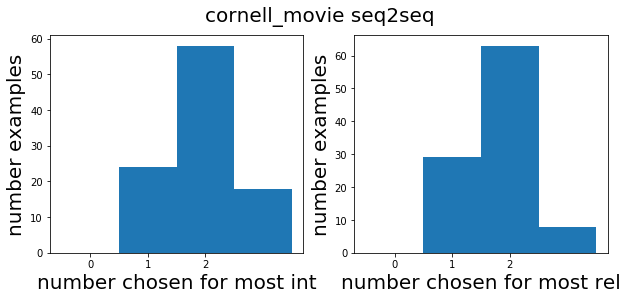

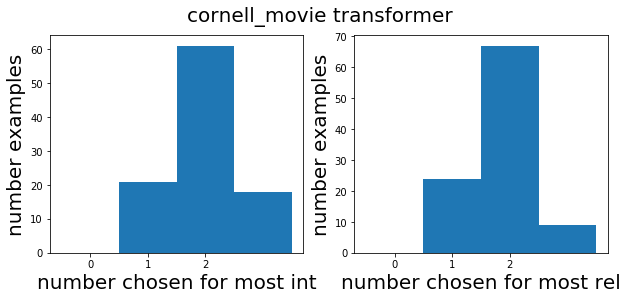

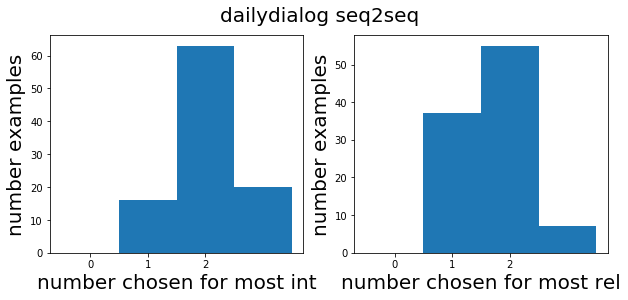

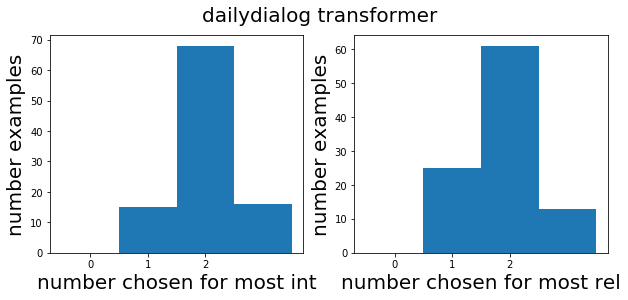

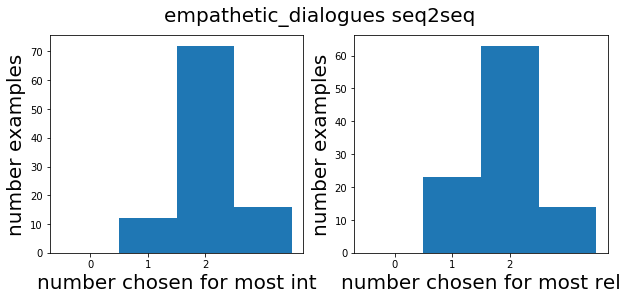

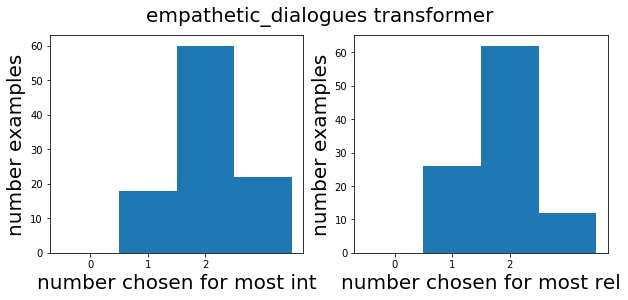

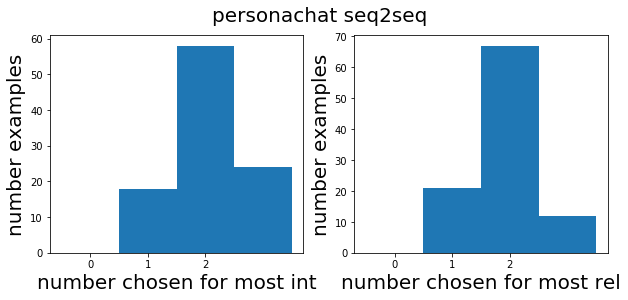

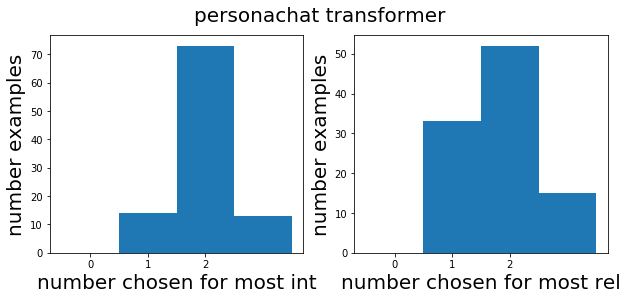

In [337]:
for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    num_most_int = []
    num_most_rel = []
    for context, df in setting_df.groupby('context'):
        num_most_int.append(len(df['most_int'].unique()))
        num_most_rel.append(len(df['most_rel'].unique()))

    ax[0].hist(num_most_int, bins=np.arange(5)-.5)
    ax[0].set_xticks(np.arange(3))
    ax[0].set_xlabel('number chosen for most int', fontsize=20)
    ax[0].set_ylabel('number examples', fontsize=20)
#     ax[0].set_title('%s %s' % (dataset, model), fontsize=20)
#     plt.show()

    ax[1].hist(num_most_rel, bins=np.arange(5)-.5)
    ax[1].set_xlabel('number chosen for most rel', fontsize=20)
    ax[1].set_ylabel('number examples', fontsize=20)
#     ax[1].set_title('%s %s' % (dataset, model), fontsize=20)
    ax[1].set_xticks(np.arange(3))
    plt.suptitle('%s %s' % (dataset, model), fontsize=20)
    plt.show()

# Look at how often a method is chosen for most relevant/interesting. 

In [ ]:
for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    some_int = (~setting_df['none_int'])
    some_rel = (~setting_df['none_rel']) 
    
    int_df = setting_df[some_int]
    rel_df = setting_df[some_rel]
    
    
    print(dataset, model)
    print('=========')
    data_model_key = '%s_%s' % (dataset, model)
    
    fig, ax = plt.subplots(1, 2)
    for m, method in enumerate(method_order): 
        ax[0].bar(m, np.sum(int_df['most_int'] == method))
        ax[1].bar(m, np.sum(rel_df['most_rel'] == method))
    
    
    ax[0].set_xticks(np.arange(3))
    ax[0].set_xticklabels(method_order)
    ax[0].set_title('Most interesting', fontsize=14)
    ax[0].set_ylabel('Number input', fontsize=20)
#     ax[0].set_title('%s %s' % (dataset, model), fontsize=20)
#     plt.show()

    ax[1].set_title('Most relevant', fontsize=14)
#     ax[1].set_ylabel('Number examples', fontsize=20)
#     ax[1].set_title('%s %s' % (dataset, model), fontsize=20)
    ax[1].set_xticks(np.arange(3))
    ax[1].set_xticklabels(method_order)
    
    
#     cross_mat = np.NaN * np.zeros((len(method_order), len(method_order)))
#     for i, m1 in enumerate(method_order):
#         for j, m2 in enumerate(method_order):
#             cross_mat[i,j] = np.sum((df['most_int'] == m1) & (df['most_rel'] == m2))
            
#     plt.pcolor(cross_mat, vmin=0, vmax=50)
#     plt.xticks(.5 + np.arange(len(method_order)), method_order)
#     plt.yticks(.5 + np.arange(len(method_order)), method_order)
#     plt.xlabel('Selected as most relevant')
#     plt.ylabel('Selected as most interesting')
#     plt.colorbar(label='Number of examples')
#     ind = np.arange(len(method_order))
    plt.suptitle('All input: %s' % (data_model_key, ), fontsize=14)
    plt.show()

## Exclude example without worker majority. 

In [ ]:
for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    some_int = (~setting_df['none_int'])
    some_rel = (~setting_df['none_rel']) 
    
    int_df = setting_df[some_int]
    rel_df = setting_df[some_rel]
    
    rel_counts = np.zeros(len(method_order))
    int_counts = np.zeros(len(method_order))
    
    for context, ex_df in rel_df.groupby('context'):
        c = Counter(ex_df['most_rel'])
        if c.most_common(1)[0][1] > 1:
            rel_counts[method_order.index(c.most_common(1)[0][0])] += 1
            
    for context, ex_df in int_df.groupby('context'):
        c = Counter(ex_df['most_int'])
        if c.most_common(1)[0][1] > 1:
            int_counts[method_order.index(c.most_common(1)[0][0])] += 1
            
            
    
    print(dataset, model)
    print('=========')
    data_model_key = '%s_%s' % (dataset, model)
    
    fig, ax = plt.subplots(1, 2)
    for m, method in enumerate(method_order): 
        ax[0].bar(m, int_counts[m])
        ax[1].bar(m, rel_counts[m])
     
    ax[0].set_xticks(np.arange(3))
    ax[0].set_xticklabels(method_order)
    ax[0].set_title('Most interesting', fontsize=14)
    ax[0].set_ylabel('Number examples', fontsize=20)

    ax[1].set_title('Most relevant', fontsize=14)
    ax[1].set_xticks(np.arange(3))
    ax[1].set_xticklabels(method_order)
    
    plt.suptitle('Majority only: %s' % (data_model_key,), fontsize=14)
    plt.show()

# Relationship of best and most relevant

In [ ]:
print('Percent inputs where most relevant response also chosen as best')
print('(not grouped by example, but "none relevant" removed)')
      
for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    some_rel = (~setting_df['none_rel'])
    df = setting_df[some_rel]
    
    
    print('=========')
    print(dataset, model)

    data_model_key = '%s_%s' % (dataset, model)
    
    cor_mat = np.zeros((1, len(method_order)))
    for ind in df.index:
        most_rel_method = df.loc[ind, 'most_rel']
        j = method_order.index(most_rel_method)
        cor_mat[0, j] += df.loc[ind, most_rel_method] == 1 # ranked best overall. 
    
    print('\t\t %.2f' %(100.0*np.sum(cor_mat)/df.shape[0],))
#     plt.pcolor(cor_mat/df.shape[0], vmin=0, vmax=50)
#     plt.xticks(.5 + np.arange(len(method_order)), method_order)
# #     plt.yticks(.5 + np.arange(len(method_order)), method_order)
#     plt.xlabel('Selected as most relevant')
# #     plt.ylabel('Selected as most interesting')
#     plt.colorbar(label='Percent most relevant and mos i')
#     ind = np.arange(len(method_order))
#     plt.title('%s: Most int==most rel: %d%%' % (data_model_key, 100.0*np.sum(cross_mat[ind,ind])/np.sum(cross_mat)))
#     plt.show()

# Relationship of when interested and when relevant
There is little consistent relationship across datasets/models, but all have the most interesting match the most relevant < 25% of the time.

In [ ]:
for (dataset, model), setting_df in choice_df.groupby(['dataset', 'model']):
    
    some_int_relevant = ~(setting_df['none_rel'] & setting_df['none_int'])
    df = setting_df[some_int_relevant]
    
    
    print(dataset, model)
    print('=========')
    data_model_key = '%s_%s' % (dataset, model)
    
    cross_mat = np.NaN * np.zeros((len(method_order), len(method_order)))
    for i, m1 in enumerate(method_order):
        for j, m2 in enumerate(method_order):
            cross_mat[i,j] = np.sum((df['most_int'] == m1) & (df['most_rel'] == m2))
            
    plt.pcolor(cross_mat, vmin=0, vmax=50)
    plt.xticks(.5 + np.arange(len(method_order)), method_order)
    plt.yticks(.5 + np.arange(len(method_order)), method_order)
    plt.xlabel('Selected as most relevant')
    plt.ylabel('Selected as most interesting')
    plt.colorbar(label='Number of input')
    ind = np.arange(len(method_order))
    plt.title('%s: Most int==most rel: %d%%' % (data_model_key, 100.0*np.sum(cross_mat[ind,ind])/np.sum(cross_mat)))
    plt.show()

In [ ]:
method_order

In [ ]:
# choice_df.columns
# task, method, model
choice_df['model'].unique()

## Look at distributions of idf generated
We could run tests for distribution shifts, but everything is pretty overlapping, so I'd expect p-values to be very large. 

In [ ]:
tasks = ['cornell_movie', 'dailydialog', 'empathetic_dialogues', 'personachat']


### Build dictionaries of idf for each dataset.
idf_dict = {t:{} for t in tasks}
for task in tasks:
    
    tot_doc = open('/data/odemasi/packages/ParlAI/tmp/%s/dict_minfreq_2.tot_doc' % task, 'r').readline()
    tot_doc = float(tot_doc.strip('\n'))
    lines = open('/data/odemasi/packages/ParlAI/tmp/%s/dict_minfreq_2.doc_freq' % task, 'r').readlines()
    
    # build idf dictionary for dataset: 
    for line in lines[4:]:
        tok, ct = line.split('\t')
        idf_dict[task][tok] = np.log(tot_doc/float(ct.strip('\n')))
    
    

### Look at distribution of generated idf for each model/dataset. 

bin_edges = np.arange(0,13,.2)
generated_idf_dist = {t:{m:{} for m in ['seq2seq', 'transformer']} for t in tasks}

for (task, model), df in choice_df.groupby(['dataset', 'model']):
    
    generated_idf_dist[task][model] = np.zeros((len(method_order), len(bin_edges)-1))
    missing_toks = []
    
    for m, method in enumerate(method_order):
        responses = df['resp_%s'%method].values
        idfs_generated = []
        for resp in responses:
            for tok in resp.split(' '):
                try:
                    idfs_generated += [idf_dict[task][tok],]
                except KeyError:
                    missing_toks += [tok,]
        
        generated_idf_dist[task][model][m,:], _ = np.histogram(idfs_generated, bins=bin_edges)
    print('Missing tokens: ', missing_toks)


In [ ]:
for task in tasks:
    for model in choice_df['model'].unique():
        
        fig, axs = plt.subplots(1,2, figsize=(10,5))
        
        for m, method in enumerate(method_order):
            axs[0].plot(bin_edges[:-1], generated_idf_dist[task][model][m,:], '-o', label=method)

        axs[0].set_title('%s %s' % (task, model), fontsize=20)  
        axs[0].set_ylabel('number tokens generated', fontsize=20)  
        axs[0].legend(fontsize=18)
        axs[0].set_xlabel('idf values', fontsize=20)  
        
        s = method_order.index('swapping')
        v = method_order.index('vanilla')
        axs[1].plot(bin_edges[:-1], 0*bin_edges[:-1], 'ko-')
        axs[1].plot(bin_edges[:-1],  generated_idf_dist[task][model][s,:] - generated_idf_dist[task][model][v,:], 'ro-')
        plt.show()


# Load relevance data

In [328]:
elim_batch_name = '../batches/Batch_3629231_batch_results.csv'
elim_batch_name2 = '../batches/Batch_3636896_batch_results.csv'

# raw_elim_df = pd.read_csv(elim_batch_name)
raw_elim_df = pd.concat([pd.read_csv(elim_batch_name), 
                         pd.read_csv(elim_batch_name2)], axis=0, sort=False).reset_index()


In [329]:
raw_elim_df.shape

(486, 94)

In [330]:
# raw_elim_df['Input.model_1_3']

In [331]:

elim_df = []
for i in raw_elim_df.index:
    row = raw_elim_df.loc[i]
    hit_num = i
    worker_id = row['WorkerId']
    
    for ex in range(10): # given to each turker in a single HIT
        
        model_pieces = row['Input.model_1_%s' % (ex,)].split(' ')
        dataset, model, method = model_pieces
        
        well_formed_score = row['Answer.well_formed_%s' % (ex,)] 
        not_rel = type(row['Answer.check_rel_0_%s' % (ex,)]) == str
        
        message1 = row['Input.msg1_%s' % (ex,)]
        message2 = row['Input.msg2_%s' % (ex,)]
        response = row['Input.resp_1_%s' % (ex,)]
        
        
        elim_df.append([hit_num, worker_id, dataset, model, method, \
                          message1, message2, response, not_rel, well_formed_score])

elim_df = pd.DataFrame(elim_df, columns = ['hit_num', 'worker_id', 'dataset', 'model', 'method', \
                                               'message1', 'message2', 'response', 'not_rel', 'well_score'])

elim_df['context'] = elim_df['message1'] + elim_df['message2']

# remove examples that had an empty message 2: 
elim_df = elim_df[[type(x) == str for x in elim_df['message2']]]

## Variability on warmup question: 

In [ ]:
for warmup_resp, df in raw_elim_df.groupby('Input.warmup_response'):
    mean_score = df['Answer.well_formed_warmup'].mean()
    print('Warmup response: ', warmup_resp)
    print('Fraction flagged not-relevant: %.2f' % np.mean([type(x) == str for x in df['Answer.check_rel_1_warmup'].values]))
    print('Mean well-formed score: ', mean_score)
    plt.hist(df['Answer.well_formed_warmup'].values, bins = .5+np.arange(6))
    plt.plot([mean_score, mean_score], [0, 30], linewidth=3)
    plt.show()

In [ ]:
raw_elim_df['Answer.optionalfeedback'].values

In [ ]:
elim_df[:3]

In [ ]:
for (task, model), df in elim_df.groupby(['dataset', 'model']):
    print(task, model)
    for method, method_df in df.groupby('method'):
#         perc_not_rel = 100.*method_df['not_rel'].mean()
        perc_not_rel = 100.0 * np.mean(method_df.groupby('context')['not_rel'].agg(np.sum)>1)
        well_score = method_df['well_score'].mean()
        below_3 = np.mean(method_df.groupby('context')['well_score'].agg(np.mean) < 3)
        well_std = method_df.groupby('context')['well_score'].agg(np.mean).std()
        print('\t percent not relevant: %.2f \tmean well score (std): %.3f (%.3f) perc<3: %.2f \t %s' % \
                          (perc_not_rel, well_score, well_std, 100.0*below_3, method))
        
        

In [ ]:
method_order = ['vanilla', 'swapping', 'idf', 'face']

method_name = {'vanilla':'unweighted', 
               'swapping':'idf+swap', 
               'idf':'idf', 
               'face': 'FACE'}


dataset_name = {'cornell_movie':'Cornell Movie',
                'dailydialog':'DailyDialog',
                'empathetic': 'Empathetic Dialogues',
                'empathetic_dialogues':'Empathetic Dialogues',
                'personachat': 'Persona-Chat'}

print('Dataset & Method & Percent not relevant & Percent score $<$ 3\\\\ \hline \hline')
for (dataset, model), df in elim_df.groupby(['dataset', 'model']):
    print('\multirow{4}{*}{\parbox{1.8cm}{\\vspace{.1cm} %s}}' % dataset_name[dataset])
    
    method_grouped = df.groupby('method')
    for method in method_order:
        
        try: 
            method_df = method_grouped.get_group(method)

            perc_not_rel = 100.0 * np.mean(method_df.groupby('context')['not_rel'].agg(np.sum)>1)
            below_3 = 100.0*np.mean(method_df.groupby('context')['well_score'].agg(np.mean) < 3)
            if method=='face':
                print('\t & %s & %.1f & %.1f \\\\ \\hline' % \
                              (method_name[method], perc_not_rel, below_3))
            else: 
                print('\t & %s & %.1f & %.1f \\\\ ' % \
                              (method_name[method], perc_not_rel, below_3))
        except KeyError: 
            pass
        

In [ ]:
off = 0
method_names = []

fig, ax = plt.subplots(figsize=(10, 10))
dataset_color = {'cornell_movie':'plum',
                'dailydialog':'skyblue',
                'empathetic': 'palevioletred',
                'empathetic_dialogues':'palevioletred',
                'personachat': 'lightsalmon'}
for method, method_df in elim_df.groupby('method'):
    ind = 0
    method_names.append(method)
    for (model, task), df in method_df.groupby(['model', 'dataset']):
        well_score = df['well_score'].mean()
#         well_std = df['well_score'].std() # This is across all inputs, but we want across averged inputs? 
        well_std = df.groupby('context')['well_score'].agg(np.mean).std()
        
        if method == 'vanilla':
            plt.bar(ind + off*5, height=well_score,  yerr=well_std, color=dataset_color[task], label=task)
        else: 
            plt.bar(ind + off*5, height=well_score,  yerr=well_std, color=dataset_color[task])
        ind += 1
        
    off += 1

plt.xticks(1+5*np.arange(4), method_names, fontsize=20)
plt.yticks(np.arange(6), fontsize=20)
plt.ylabel('Well-formed score (1-5)', fontsize=20)     
plt.ylim([1,5.5])
plt.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0-box.height *.3, box.width, box.height * 0.7])

# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0, 1), ncol=2, fontsize=20)

plt.show()

In [ ]:
# df.groupby('context')['well_score'].agg([np.mean, np.size])#.std()

In [ ]:
for method in elim_df['method'].unique():
    plt.hist(elim_df.groupby('method').get_group(method)['well_score'].values, bins = 5)
    plt.title('%s (std: %s)' % (method, elim_df.groupby('method').get_group(method).groupby('context')['well_score'].agg(np.mean).std()))
    plt.show()
    

In [332]:
scored_untied_df = []

for (dataset, model, method), setting_df in elim_df.groupby(['dataset', 'model', 'method']):
    for context, df in setting_df.groupby('context'):
        if df.shape[0] !=3: 
            print(dataset, model, method, df.shape)
        scored_untied_df.append([dataset, model, method, context, df['response'].values[0],
                      df['well_score'].mean(),  
                      Counter(df['not_rel'].values).most_common(1)[0][0] == True])
        
scored_untied_df = pd.DataFrame(scored_untied_df, columns = ['dataset', 'model', 'method', 'context', 
                                                             'response', 'avg_well_score', 'not_rel'])
        

In [ ]:
for (dataset, model, method), setting_df in elim_df.groupby(['dataset', 'model', 'method']):
    print(dataset, model, method, 'missing: ', 100-len(setting_df.groupby('context').groups))
#     if len(setting_df.groupby('context').groups) < 100:
#         break
#     for context, df in setting_df.groupby('context'):

In [ ]:
len(setting_df['context'].unique())

# Load Data that Duels Vanilla & IDF

In [10]:
# raw_duel_df = pd.read_csv('batches/Batch_3630895_batch_results.csv')

raw_duel_df = pd.concat([pd.read_csv('../batches/Batch_3630895_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3636922_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3638556_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3638681_batch_results.csv')], axis=0, sort=False).reset_index()


In [11]:
raw_duel_df.shape

(246, 148)

In [12]:
dueling_methods = ['vanilla', 'idf']

duel_df = []
for i in raw_duel_df.index:
    row = raw_duel_df.loc[i]
    hit_num = i
    worker_id = row['WorkerId']
    
    for ex in range(10): # given to each turker in a single HIT
        
        if np.isnan(row['Answer.best_%s' % ex]): 
            # This may be null from the re-run subset, so skip it (and count after!)
            continue
            
        option_to_method = {}
        method_to_resp = {}
        
        for option in range(1, 2+1):
            
            model_pieces = row['Input.model_%s_%s' % (option, ex)].split(' ')
            dataset, model, method = model_pieces
                
            option_to_method[option] = method
            method_to_resp[method] = row['Input.resp_%s_%s' % (option, ex)]
            
        best_overall = option_to_method[row['Answer.best_%s' % (ex,)]]
        most_interesting = option_to_method[row['Answer.int_%s' % (ex,)]]
        most_relevant = option_to_method[row['Answer.rel_%s' % (ex,)]]
        none_int = type(row['Answer.check_int_%s'% (ex,)]) == str
        none_rel = type(row['Answer.check_rel_%s'% (ex,)]) == str
        message1 = row['Input.msg1_%s' % (ex,)]
        message2 = row['Input.msg2_%s' % (ex,)]
        
        
        duel_df.append([hit_num, worker_id, dataset, model,
                          message1, message2] + \
                        [method_to_resp[x] for x in dueling_methods] + \
                        [best_overall, most_interesting, most_relevant, none_int, none_rel])

duel_df = pd.DataFrame(duel_df, columns = ['hit_num', 'worker_id', 'dataset', \
                                           'model', 'message1', 'message2',] + \
                                           ['response_%s' % x for x in dueling_methods] + \
                                           ['best_overall', 'most_int', 'most_rel', 'none_int', 'none_rel'])

duel_df['context'] = duel_df['message1'] + duel_df['message2']


# remove examples (accidentially included) where message 2 was null
duel_df = duel_df[[type(x) == str for x in duel_df['message2']]]

In [13]:
duel_df[[type(x) != str for x in duel_df['message2']]].shape

(0, 14)

In [ ]:
print(duel_df[[type(x) == str for x in duel_df['message2']]].shape)
print(duel_df['context'].unique().shape)

In [ ]:
for (dataset, model), setting_df in duel_df.groupby(['dataset', 'model']):
    print(dataset, model, method, 'missing: ', 100-len(setting_df.groupby('context').groups))

In [ ]:
for context, setting_df in duel_df.groupby('context'):
    if setting_df.shape[0] != 6: 
        print(setting_df.shape[0], context)
#     print(dataset, model, method, 'missing: ', 100-len(setting_df.groupby('context').groups))

In [ ]:
raw_duel_df['Answer.optionalfeedback'].values

In [ ]:
np.sum(rel_and_int), rel_and_int.shape

### Look at counts of when rel & int, etc., overall.

In [102]:
print('OVERALL:')

rel_and_int = ~(duel_df['none_rel'] | duel_df['none_int'])
a = duel_df['most_rel'] != duel_df['most_int']
b = duel_df['most_rel'] == duel_df['best_overall']
print('Fraction most_rel != most_int %.3f %d' %  (np.mean(a[rel_and_int]), len(a[rel_and_int])))
print(sum(a[rel_and_int]))
print("Fraction most_rel == best %.3f %d" %  (np.mean(b[~duel_df['none_rel']]), len(b[~duel_df['none_rel']])))
print(sum(b[~duel_df['none_rel']]))

print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f %d" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int]), len(a[rel_and_int])))


# for (dataset, model), setting_df in duel_df.groupby(['dataset', 'model']):
    
#     print("\n\n%s %s" % (dataset, model))
#     print('Counts over all:')
#     print('Best overall: ', Counter(setting_df['best_overall']))
#     print('Most Interesting: ', Counter(setting_df['most_int']))
#     print('Most relevant: ', Counter(setting_df['most_rel']))
    
#     a = setting_df['most_rel'] != setting_df['most_int']
#     b = setting_df['most_rel'] == setting_df['best_overall']
#     print('Fraction most_rel != most_int %.3f' %  np.mean(a))
#     print("Fraction most_rel == best %.3f" %  np.mean(b))
#     print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
#           (np.sum(a&b) / np.sum(a)))





print('\n\n\nUNTIED OVERALL:')

rel_and_int = ~(duel_untied_df['none_rel'] | duel_untied_df['none_int'])
a = duel_untied_df['most_rel'] != duel_untied_df['most_int']
b = duel_untied_df['most_rel'] == duel_untied_df['best_overall']
print('Fraction most_rel != most_int %.3f %d' % (np.mean(a[rel_and_int]), len(a)))
print()
print("Fraction most_rel == best %.3f %d" %  (np.mean(b[~duel_untied_df['none_rel']]), len(b)))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f %d" % \
      ((np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])), len(a)))



OVERALL:
Fraction most_rel != most_int 0.527 1841
970
Fraction most_rel == best 0.704 1979
1394
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.792 1841



UNTIED OVERALL:
Fraction most_rel != most_int 0.501 800

Fraction most_rel == best 0.680 800
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.743 800


In [19]:
duel_untied_df.columns

Index(['dataset', 'model', 'context', 'response_vanilla', 'response_idf',
       'best_overall', 'most_rel', 'most_int', 'none_rel', 'none_int'],
      dtype='object')

In [45]:
import nltk
def test(x, y):
    if nltk.edit_distance(x,y) > 5:
        return True
    else:
        return False


,dataset,model,context,response_vanilla,response_idf,best_overall,most_rel,most_int,none_rel,none_int
0,cornell_movie,seq2seq,!#@$ maxine.we wish.,and you 're not gon na do it .,i 'm sorry for you .,vanilla,vanilla,vanilla,False,False
1,cornell_movie,seq2seq,-- there's no time ---- we'll explain it --,-- i --,shut up ! ! ! ! ! !,idf,idf,idf,True,False
2,cornell_movie,seq2seq,"all right, i guess. one hell of a hangover. ...",i do n't know .,i do n't know what i 'm doing here .,idf,idf,vanilla,False,False
3,cornell_movie,seq2seq,"all right. let me out.you know, new hell reall...",yeah .,what do you mean ?,vanilla,vanilla,idf,False,False
4,cornell_movie,seq2seq,and the beauty of it is she'll never have to k...,so ?,"well , we 'll be fine .",vanilla,idf,vanilla,False,False
5,cornell_movie,seq2seq,"calm down, please. this man needs help and you...",i do n't know .,"well , i do n't know .",vanilla,vanilla,vanilla,False,True
6,cornell_movie,seq2seq,do you have a baby?no... the closest...,yes .,i do n't know ...,idf,vanilla,vanilla,False,False
7,cornell_movie,seq2seq,"dr. towler, who was in the operating room with...","yes , sir .",that 's right .,idf,vanilla,idf,False,False
8,cornell_movie,seq2seq,except for the hot affairs we'll have twice a ...,i do n't know .,okay ?,vanilla,idf,idf,False,False
10,cornell_movie,seq2seq,for being a bootlegger?for being a man.,i know .,do n't worry about it ?,vanilla,idf,idf,False,False


In [55]:
no_similar_resps = duel_untied_df[duel_untied_df.apply(lambda x: test(x["response_vanilla"], x["response_idf"]), axis=1)]
a = no_similar_resps['most_rel'] != no_similar_resps['most_int']
b = no_similar_resps['most_rel'] == no_similar_resps['best_overall']
print("No similar responses")
print('Fraction most_rel != most_int %.3f' %  np.mean(a[rel_and_int]))
print("Fraction most_rel == best %.3f" %  np.mean(b[~duel_untied_df['none_rel']]))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])))
print("\n\n\n")

no_short_resps = duel_untied_df[duel_untied_df['response_vanilla'].apply(lambda x: len(x.split(" "))>6) & duel_untied_df['response_idf'].apply(lambda x: len(x.split(" "))>6)]
a = no_short_resps['most_rel'] != no_short_resps['most_int']
b = no_short_resps['most_rel'] == no_short_resps['best_overall']
print("No short responses")
print('Fraction most_rel != most_int %.3f' %  np.mean(a[rel_and_int]))
print("Fraction most_rel == best %.3f" %  np.mean(b[~duel_untied_df['none_rel']]))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])))
print("\n\n\n")

no_similar_or_short_resps = duel_untied_df[duel_untied_df.apply(lambda x: test(x["response_vanilla"], x["response_idf"]), axis=1) & (duel_untied_df['response_vanilla'].apply(lambda x: len(x.split(" "))>6) & duel_untied_df['response_idf'].apply(lambda x: len(x.split(" "))>6))]
a = no_similar_or_short_resps['most_rel'] != no_similar_or_short_resps['most_int']
b = no_similar_or_short_resps['most_rel'] == no_similar_or_short_resps['best_overall']
print("No short or similar responses")
print('Fraction most_rel != most_int %.3f' %  np.mean(a[rel_and_int]))
print("Fraction most_rel == best %.3f" %  np.mean(b[~duel_untied_df['none_rel']]))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])))
print("\n\n\n")

one_long_resp = duel_untied_df[(duel_untied_df['response_vanilla'].apply(lambda x: len(x.split(" "))>6) & duel_untied_df['response_idf'].apply(lambda x: len(x.split(" "))<6) | duel_untied_df['response_vanilla'].apply(lambda x: len(x.split(" "))<6) & duel_untied_df['response_idf'].apply(lambda x: len(x.split(" "))>6))]
a = one_long_resp['most_rel'] != one_long_resp['most_int']
b = one_long_resp['most_rel'] == one_long_resp['best_overall']
print("One long and one short response")
print('Fraction most_rel != most_int %.3f' %  np.mean(a[rel_and_int]))
print("Fraction most_rel == best %.3f" %  np.mean(b[~duel_untied_df['none_rel']]))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])))
print("\n\n\n")


no_both_short = duel_untied_df[~(duel_untied_df['response_vanilla'].apply(lambda x: len(x.replace(" .","").replace(" ,","").replace(" ?","").replace(" !","").split(" "))<6) & duel_untied_df['response_idf'].apply(lambda x: len(x.split(" "))<6))]
a = no_both_short['most_rel'] != no_both_short['most_int']
b = no_both_short['most_rel'] == no_both_short['best_overall']
print("One long and one short response")
print('Fraction most_rel != most_int %.3f' %  np.mean(a[rel_and_int]))
print("Fraction most_rel == best %.3f" %  np.mean(b[~duel_untied_df['none_rel']]))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])))
print("\n\n\n")

No similar responses
Fraction most_rel != most_int 0.500
Fraction most_rel == best 0.677
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.746




No short responses
Fraction most_rel != most_int 0.464
Fraction most_rel == best 0.709
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.798




No short or similar responses
Fraction most_rel != most_int 0.466
Fraction most_rel == best 0.708
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.798




One long and one short response
Fraction most_rel != most_int 0.500
Fraction most_rel == best 0.661
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.762




One long and one short response
Fraction most_rel != most_int 0.497
Fraction most_rel == best 0.684
Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) 0.764






In [60]:
def is_short(string):
    string = string.replace(" .","").replace(" ,","").replace(" ?","").replace(" !","")
    if string.split(" ") > 5:
        return True
    return False
no_both_short = duel_untied_df[~(duel_untied_df['response_vanilla'].apply(lambda x: ~is_short(x)) & duel_untied_df['response_idf'].apply(lambda x: ~is_short(x)))]
a = no_both_short['most_rel'] != no_both_short['most_int']
b = no_both_short['most_rel'] == no_both_short['best_overall']
print("One long and one short response")
print('Fraction most_rel != most_int %.3f' %  np.mean(a[rel_and_int]))
print("Fraction most_rel == best %.3f" %  np.mean(b[~duel_untied_df['none_rel']]))
print("Fraction ((most_rel != most_int) & (most_rel == best))/(most_rel != most_int) %.3f" % \
      (np.sum(a[rel_and_int] & b[rel_and_int]) / np.sum(a[rel_and_int])))
print("\n\n\n")

TypeError: '>' not supported between instances of 'list' and 'int'

In [56]:
one_long_resp

,dataset,model,context,response_vanilla,response_idf,best_overall,most_rel,most_int,none_rel,none_int
1,cornell_movie,seq2seq,-- there's no time ---- we'll explain it --,-- i --,shut up ! ! ! ! ! !,idf,idf,idf,True,False
2,cornell_movie,seq2seq,"all right, i guess. one hell of a hangover. ...",i do n't know .,i do n't know what i 'm doing here .,idf,idf,vanilla,False,False
4,cornell_movie,seq2seq,and the beauty of it is she'll never have to k...,so ?,"well , we 'll be fine .",vanilla,idf,vanilla,False,False
5,cornell_movie,seq2seq,"calm down, please. this man needs help and you...",i do n't know .,"well , i do n't know .",vanilla,vanilla,vanilla,False,True
14,cornell_movie,seq2seq,"he'll kill you, lenny.my wife used to call me ...",what ?,"yeah , he 's gon na kill him .",idf,idf,vanilla,False,False
16,cornell_movie,seq2seq,how are they with kids?they're great with kids...,i do n't know .,"well , i do n't know what i 'm doing here .",vanilla,vanilla,vanilla,False,False
25,cornell_movie,seq2seq,"my name is smith - well, that you seem to have...",i do n't know .,i do n't know what i 'm doing here .,idf,idf,vanilla,False,False
26,cornell_movie,seq2seq,"no way, jude. i'm out.you're never out, fergus.",i do n't know .,i do n't know what i 'm doing here .,vanilla,vanilla,vanilla,False,False
28,cornell_movie,seq2seq,"oh, the best i ever had. absolutely the best.y...",i do n't know .,"well , i do n't know .",idf,idf,vanilla,False,False
29,cornell_movie,seq2seq,"pack the bags, we have to move.also, this is y...","yes , sir .",i do n't care about it .,vanilla,vanilla,idf,False,False


### Look at counts when total crap is removed. 

In [ ]:
for (dataset, model), setting_df in duel_df.groupby(['dataset', 'model']):
    
    print("\n\n%s %s" % (dataset, model))
    print('Counts with crap removed:')
    print('Best overall with not relevant and not interesting removed: ', 
          Counter(setting_df['best_overall'][~(setting_df['none_int'] & setting_df['none_rel'])]), 
          ' (%s removed)' % np.sum(setting_df['none_int'] & setting_df['none_rel']))

    print('Most int with not interesting removed: ', 
          Counter(setting_df['most_int'][~setting_df['none_int']]), 
          ' (%s removed)' % np.sum(setting_df['none_int']))

    print('Most relevant with not relevant removed: ', 
          Counter(setting_df['most_rel'][~setting_df['none_rel']]), 
          ' (%s removed)' % np.sum(setting_df['none_rel']))

In [ ]:
duel_df[:3]

In [ ]:
# duel_df.columns
# df['response'][0]
df['response_vanilla'].values[0]

In [15]:
duel_untied_df = []

for (dataset, model), setting_df in duel_df.groupby(['dataset', 'model']):
    for context, df in setting_df.groupby('context'):
        duel_untied_df.append([dataset, model, context, 
                               df['response_vanilla'].values[0], df['response_idf'].values[0],
                              Counter(df['best_overall'].values).most_common(1)[0][0],
                              Counter(df['most_rel'].values).most_common(1)[0][0],
                              Counter(df['most_int'].values).most_common(1)[0][0], 
                              Counter(df['none_rel'].values).most_common(1)[0][0] == True, 
                              Counter(df['none_int'].values).most_common(1)[0][0] == True])
duel_untied_df = pd.DataFrame(duel_untied_df, columns = ['dataset', 'model', 'context', 
                                                         'response_vanilla', 'response_idf',
                                                         'best_overall', 'most_rel', 'most_int', 
                                                         'none_rel', 'none_int'])



In [1]:
print('Counts over examples (i.e., tie-broken):')

for (dataset, model), setting_df in duel_untied_df.groupby(['dataset', 'model']):
    
    print("\n\n%s %s" % (dataset, model))
    print('Best overall: ', Counter(setting_df['best_overall']))
    print('Most Interesting: ', Counter(setting_df['most_int']))
    print('Most relevant: ', Counter(setting_df['most_rel']))
    
    print('Fraction most_rel != most_int %.3f' %  np.mean(setting_df['most_rel'] != setting_df['most_int']))
    print("Fraction most_rel == best %.3f" %  np.mean(setting_df['most_rel'] == setting_df['best_overall']))

Counts over examples (i.e., tie-broken):


NameError: name 'duel_untied_df' is not defined

In [ ]:
print('Counts with crap removed:')

for (dataset, model), setting_df in duel_untied_df.groupby(['dataset', 'model']):
    
    print("\n\n%s %s" % (dataset, model))
    print('Best overall with not relevant and not interesting removed: ', 
          Counter(setting_df['best_overall'][~(setting_df['none_int'] & setting_df['none_rel'])]), 
          ' (%s removed)' % np.sum(setting_df['none_int'] & setting_df['none_rel']))

    print('Most int with not interesting removed: ', 
          Counter(setting_df['most_int'][~setting_df['none_int']]), 
          ' (%s removed)' % np.sum(setting_df['none_int']))

    print('Most relevant with not relevant removed: ', 
          Counter(setting_df['most_rel'][~setting_df['none_rel']]), 
          ' (%s removed)' % np.sum(setting_df['none_rel']))

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

for (model, dataset), setting_df in duel_untied_df.groupby(['model', 'dataset']):
    
    c_best = Counter(setting_df['best_overall'])
    c_int = Counter(setting_df['most_int'][~setting_df['none_int']])
    c_rel = Counter(setting_df['most_rel'][~setting_df['none_rel']])
    
    if model== 'transformer':
        sym = '*'
        mod='trans'
    else: 
        sym='o'
        mod='s2s'
    ax.plot([1, 2], [c_int['vanilla'], c_int['idf']],'%s-'%sym, label='%s (%s)' % (dataset, mod), color=dataset_color[dataset])
    ax.plot([4, 5], [c_rel['vanilla'], c_rel['idf']],'%s-'%sym, color=dataset_color[dataset])
    ax.plot([7, 8], [c_best['vanilla'], c_best['idf']],'%s-'%sym, color=dataset_color[dataset])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.legend()
plt.xlabel('Most Interesting   Most Relevant  Best Overall',fontsize=10)
plt.ylabel('Number responses',fontsize=16)
plt.xticks([1,2, 4,5, 7,8], ['Unweighted', 'IDF', 'Unweighted', 'IDF','Unweighted', 'IDF'])
plt.ylim([30,70])
plt.show()

In [ ]:
dataset_abbrv = {'cornell_movie':'Cor',
                'dailydialog':'Dai',
                'empathetic': 'Emp',
                'empathetic_dialogues':'Emp',
                'personachat': 'Per'}
model_abbrv = {'seq2seq':'S2S',
                'transformer': "Tfm"}
# dataset_color = {'cornell_movie':'plum',
#                 'dailydialog':'skyblue',
#                 'empathetic': 'palevioletred',
#                 'empathetic_dialogues':'palevioletred',
#                 'personachat': 'lightsalmon'}

fig, ax = plt.subplots(figsize=(4,10))
h = 0
plt.plot([50,50],[-1, 27], color='grey', linewidth=3)

ylabels = []
for (model, dataset), setting_df in duel_untied_df.groupby(['model', 'dataset']):
    
    c_best = Counter(setting_df['best_overall'])
    c_int = Counter(setting_df['most_int'][~setting_df['none_int']])
    c_rel = Counter(setting_df['most_rel'][~setting_df['none_rel']])
    
    d = float(sum(c_int.values()))
    
    plt.barh(h, 100.*c_int['vanilla']/d, left=0, color='pink')
    plt.barh(h, 100.*c_int['idf']/d, left=100.*c_int['vanilla']/d, color='mediumorchid')
    
    
    d = float(sum(c_rel.values()))
    plt.barh(h+9, 100.*c_rel['vanilla']/d, left=0, color='pink')
    plt.barh(h+9, 100.*c_rel['idf']/d, left=100.*c_rel['vanilla']/d, color='mediumorchid')
    
    
    d = float(sum(c_best.values()))
    if model=='transformer' and dataset=='personachat':
        plt.barh(h+18, 100.*c_best['vanilla']/d, left=0, color='pink', label='unweighted')
        plt.barh(h+18, 100.*c_best['idf']/d, left=100.*c_best['vanilla']/d, color='mediumorchid', label='idf')
    else:
        plt.barh(h+18, 100.*c_best['vanilla']/d, left=0, color='pink')
        plt.barh(h+18, 100.*c_best['idf']/d, left=100.*c_best['vanilla']/d, color='mediumorchid')
    
    ylabels.append('%s:%s' % (dataset_abbrv[dataset], model_abbrv[model]))
    
#     plt.plot([3, 4], [c_rel['vanilla'], c_rel['idf']],'o-')
#     plt.plot([5, 6], [c_best['vanilla'], c_best['idf']],'o-')
    h += 1
    
# plt.legend()
plt.ylabel('Most Interesting  Most Relevant   Best Overall', fontsize=16)
plt.xlabel('Percent of examples',fontsize=20)
# plt.xticks(1+np.arange(6), ['Unweighted', 'IDF', 'Unweighted', 'IDF','Unweighted', 'IDF'])
plt.yticks(np.arange(3*(len(ylabels)+1)), ylabels + [''] + ylabels + [''] + ylabels, fontsize=13)
plt.xlim([0,100])
plt.ylim([-1, 26])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0-box.height *.3, box.width, box.height * 0.7])

# Put a legend to the right of the current axis
ax.legend(loc='lower left', bbox_to_anchor=(0, 1), ncol=2, fontsize=14)


plt.show()

# Append additional metrics of diversity

In [ ]:
idf_dict.keys()

In [ ]:
# scored_untied_df.columns

for ind in scored_untied_df.index:
    
    if scored_untied_df.loc[ind, 'dataset'] == 'empathetic': 
        dataset_idf_dict = idf_dict['empathetic_dialogues']
    else:
        dataset_idf_dict = idf_dict[scored_untied_df.loc[ind, 'dataset']]
    
    resp_a = scored_untied_df.loc[ind, 'response'].split(' ')
    idf_a = [dataset_idf_dict[x] for x in resp_a if x in dataset_idf_dict.keys()]
    tmp = [x for x in resp_a if x not in dataset_idf_dict.keys()]
    if tmp != []:
        print(tmp)
    scored_untied_df.loc[ind, 'len'] = len(resp_a)
    scored_untied_df.loc[ind, 'max_idf'] = np.max(idf_a)
    scored_untied_df.loc[ind, 'avg_idf'] = np.mean(idf_a)
    

In [ ]:
scored_untied_df[:3]

In [ ]:
for ind in duel_untied_df.index:
    
    dataset_idf_dict = idf_dict[duel_untied_df.loc[ind, 'dataset']]
    
    for suff in ['idf' ,'vanilla']:
        resp_a = duel_untied_df.loc[ind, 'response_%s'%suff].split(' ')
        idf_a = [dataset_idf_dict[x] for x in resp_a if x in dataset_idf_dict.keys()]
        tmp = [x for x in resp_a if x not in dataset_idf_dict.keys()]
        if tmp != []:
            print(tmp)
        duel_untied_df.loc[ind, 'len_%s'%suff] = len(resp_a)
        duel_untied_df.loc[ind, 'max_idf_%s'%suff] = np.max(idf_a)
        duel_untied_df.loc[ind, 'avg_idf_%s'%suff] = np.mean(idf_a)

### Look at how wellness score relates to auto-metrics

In [ ]:
for (dataset, model), df in scored_untied_df.groupby(['dataset', 'model']):
    fig, ax = plt.subplots(1,3, figsize=(15,4))
    ax[0].plot(df['avg_idf'], df['avg_well_score'], 'o', alpha=.3)
    ax[0].set_xlabel('avg_idf')
    ax[1].plot(df['max_idf'], df['avg_well_score'], 'o', alpha=.3)
    ax[1].set_xlabel('max_idf')
    ax[2].plot(df['len'], df['avg_well_score'], 'o', alpha=.3)
    ax[2].set_xlabel('response length')
    
    ax[0].set_ylabel('avg. well-formed score')
    plt.suptitle('%s %s' % (dataset, model))
    plt.show()

### RELEVANCE: 

In [ ]:
hist_info_rel = []

for (dataset, model), df in duel_untied_df.groupby(['dataset', 'model']):
    fig, ax = plt.subplots(1,3, figsize=(15,4))
    
    diffs = np.NaN*np.zeros((3, df.shape[0]))
    
    for i, ind in enumerate(df.index):
        # win on right
        
        if df.loc[ind, 'most_rel'] == 'vanilla':
            ax[0].plot([0, 1], [df.loc[ind, 'avg_idf_idf'], df.loc[ind, 'avg_idf_vanilla']], 'bo-', alpha=.3)
            ax[1].plot([0, 1], [df.loc[ind, 'max_idf_idf'], df.loc[ind, 'max_idf_vanilla']], 'bo-', alpha=.3)
            ax[2].plot([0, 1], [df.loc[ind, 'len_idf'], df.loc[ind, 'len_vanilla']], 'bo-', alpha=.3)
            
            diffs[0, i] = df.loc[ind, 'avg_idf_vanilla'] - df.loc[ind, 'avg_idf_idf'] 
            diffs[1, i] = df.loc[ind, 'max_idf_vanilla'] - df.loc[ind, 'max_idf_idf']
            diffs[2, i] = df.loc[ind, 'len_vanilla'] - df.loc[ind, 'len_idf']

        else: # idf won
            ax[0].plot([0, 1], [df.loc[ind, 'avg_idf_vanilla'], df.loc[ind, 'avg_idf_idf']], 'b-o', alpha=.3)
            ax[1].plot([0, 1], [df.loc[ind, 'max_idf_vanilla'], df.loc[ind, 'max_idf_idf']], 'b-o', alpha=.3)
            ax[2].plot([0, 1], [df.loc[ind, 'len_vanilla'], df.loc[ind, 'len_idf']], 'b-o', alpha=.3)
            
            diffs[0, i] = df.loc[ind, 'avg_idf_idf'] - df.loc[ind, 'avg_idf_vanilla']
            diffs[1, i] = df.loc[ind, 'max_idf_idf'] - df.loc[ind, 'max_idf_vanilla']
            diffs[2, i] = df.loc[ind, 'len_idf'] - df.loc[ind, 'len_vanilla']
            
    hist_info_rel.append([dataset, model, diffs])
    
    ax[0].set_ylabel('avg_idf')
    ax[1].set_ylabel('max_idf')
    ax[2].set_ylabel('response length')
                                
    ax[0].set_xticks([0,1])
    ax[0].set_xticklabels(['lose', 'win'])
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels(['lose', 'win'])
    ax[2].set_xticks([0,1])
    ax[2].set_xticklabels(['lose', 'win'])
    
    plt.suptitle('RELEVANCE: %s %s' % (dataset, model))
    plt.show()
    
    

    

In [ ]:

fig, ax = plt.subplots(1,3, figsize=(15,4))

for i in range(len(hist_info)):
    
    diffs = hist_info_rel[i][2]
    
    y, bin_edges = np.histogram(diffs[0,:], bins=np.arange(-10, 10, 1))
    ax[0].plot(bin_edges[:-1], y, 'o-', label='%s %s' % (hist_info_rel[0], hist_info_rel[1]))
    
    y, bin_edges = np.histogram(diffs[1,:], bins=np.arange(-10, 10, 1))
    ax[1].plot(bin_edges[:-1], y, 'o-', label='%s %s' % (hist_info_rel[0], hist_info_rel[1]))
    
    y, bin_edges = np.histogram(diffs[2,:], bins=np.arange(-30, 30, 2))
    ax[2].plot(bin_edges[:-1], y, 'o-', label='%s %s' % (hist_info_rel[0], hist_info_rel[1]))
    
    ax[0].set_xlabel('difference of avg_idf of win - lose')
    ax[1].set_xlabel('difference of max_idf of win - lose')
    ax[2].set_xlabel('difference of length of win - lose')
    ax[0].set_ylabel('number of examples')
    
plt.suptitle('RELEVANT')
plt.show()

### INTERESTING

In [ ]:
hist_info = []

for (dataset, model), df in duel_untied_df.groupby(['dataset', 'model']):
    fig, ax = plt.subplots(1,3, figsize=(15,4))
    
    diffs = np.NaN*np.zeros((3, df.shape[0]))
    
    for i, ind in enumerate(df.index):
        # win on right
        
        if df.loc[ind, 'most_int'] == 'vanilla':
            ax[0].plot([0, 1], [df.loc[ind, 'avg_idf_idf'], df.loc[ind, 'avg_idf_vanilla']], 'o-', alpha=.3, color='purple')
            ax[1].plot([0, 1], [df.loc[ind, 'max_idf_idf'], df.loc[ind, 'max_idf_vanilla']], 'o-', alpha=.3, color='purple')
            ax[2].plot([0, 1], [df.loc[ind, 'len_idf'], df.loc[ind, 'len_vanilla']], 'o-', alpha=.3, color='purple')
            
            diffs[0, i] = df.loc[ind, 'avg_idf_vanilla'] - df.loc[ind, 'avg_idf_idf']
            diffs[1, i] = df.loc[ind, 'max_idf_vanilla'] - df.loc[ind, 'max_idf_idf']
            diffs[2, i] = df.loc[ind, 'len_vanilla'] - df.loc[ind, 'len_idf']
            
        else: # idf won
            ax[0].plot([0, 1], [df.loc[ind, 'avg_idf_vanilla'], df.loc[ind, 'avg_idf_idf']], 'o-', alpha=.3, color='purple')
            ax[1].plot([0, 1], [df.loc[ind, 'max_idf_vanilla'], df.loc[ind, 'max_idf_idf']], 'o-', alpha=.3, color='purple')
            ax[2].plot([0, 1], [df.loc[ind, 'len_vanilla'], df.loc[ind, 'len_idf']], 'o-', alpha=.3, color='purple')
            
            diffs[0, i] = df.loc[ind, 'avg_idf_idf'] - df.loc[ind, 'avg_idf_vanilla']
            diffs[1, i] = df.loc[ind, 'max_idf_idf'] - df.loc[ind, 'max_idf_vanilla']
            diffs[2, i] = df.loc[ind, 'len_idf'] - df.loc[ind, 'len_vanilla']
            
    ax[0].set_ylabel('avg_idf')
    ax[1].set_ylabel('max_idf')
    ax[2].set_ylabel('response length')
                                
    ax[0].set_xticks([0,1])
    ax[0].set_xticklabels(['lose', 'win'])
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels(['lose', 'win'])
    ax[2].set_xticks([0,1])
    ax[2].set_xticklabels(['lose', 'win'])
    
    plt.suptitle('INTERESTING: %s %s' % (dataset, model))
    plt.show()
    
    
    hist_info.append([dataset, model, diffs])
    
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

for i in range(len(hist_info)):
    
    diffs = hist_info[i][2]
    
    y, bin_edges = np.histogram(diffs[0,:], bins=np.arange(-10, 10, 1))
    ax[0].plot(bin_edges[:-1], y, 'o-', label='%s %s' % (hist_info[0], hist_info[1]))
    
    y, bin_edges = np.histogram(diffs[1,:], bins=np.arange(-10, 10, 1))
    ax[1].plot(bin_edges[:-1], y, 'o-', label='%s %s' % (hist_info[0], hist_info[1]))
    
    y, bin_edges = np.histogram(diffs[2,:], bins=np.arange(-30, 30, 2))
    ax[2].plot(bin_edges[:-1], y, 'o-', label='%s %s' % (hist_info[0], hist_info[1]))
    
    ax[0].set_xlabel('difference of avg_idf of win - lose')
    ax[1].set_xlabel('difference of max_idf of win - lose')
    ax[2].set_xlabel('difference of length of win - lose')
    ax[0].set_ylabel('number of examples')
    
plt.suptitle('INTERESTING')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))

for i in range(len(hist_info)):
    
    diffs = hist_info[i][2]

    y, bin_edges = np.histogram(diffs[1,:], bins=np.arange(-10, 10, 1))
    ax.plot(bin_edges[:-1], y, 'o-g', label='%s %s' % (hist_info[0], hist_info[1]), alpha=.4)


    ax.set_xlabel('max_idf of win - max_idf lose', fontsize=18)
    ax.set_ylabel('Number of examples', fontsize=18)
    
# plt.suptitle('INTERESTING')
plt.show()

In [322]:
# scored_untied_df.merge(duel_untied_df)
t2 = duel_untied_df
# t2

In [333]:
t1_vanilla = scored_untied_df[scored_untied_df['method'] == 'vanilla'][['dataset', 'model', 
                                                                    'context', 'avg_well_score', 'not_rel']]
t1_vanilla = t1_vanilla.rename(columns = {'avg_well_score':'avg_well_score_vanilla', 'not_rel':'not_rel_vanilla'})

t1_idf = scored_untied_df[scored_untied_df['method'] == 'idf'][['dataset', 'model', 
                                                                    'context', 'avg_well_score', 'not_rel']]
t1_idf = t1_idf.rename(columns = {'avg_well_score':'avg_well_score_idf', 'not_rel':'not_rel_idf'})

In [334]:
# t3 = t1.merge(t2, on=['dataset', 'model', 'context'], how='left')
t3 = t2.merge(t1_vanilla, on=['dataset', 'model', 'context'], how = 'right')
t3 = t3.merge(t1_idf, on=['dataset', 'model', 'context'], how = 'right')

In [ ]:
# t3.shape

In [ ]:
for (dataset, model), df in t3.groupby(['dataset', 'model']):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    diffs = np.NaN*np.zeros((3, df.shape[0]))
    
    for i, ind in enumerate(df.index):
        # win on right
        if df.loc[ind, 'most_rel'] == 'vanilla':
            ax[0].plot([0, 1], [df.loc[ind, 'avg_well_score_idf'], df.loc[ind, 'avg_well_score_vanilla']], 'bo-', alpha=.3)
        else: # idf won
            ax[0].plot([0, 1], [df.loc[ind, 'avg_well_score_vanilla'], df.loc[ind, 'avg_well_score_idf']], 'b-o', alpha=.3)
            
    
    for i, ind in enumerate(df.index):
        # win on right
        if df.loc[ind, 'most_int'] == 'vanilla':
            ax[1].plot([0, 1], [df.loc[ind, 'avg_well_score_idf'], df.loc[ind, 'avg_well_score_vanilla']], 'bo-', alpha=.3)
        else: # idf won
            ax[1].plot([0, 1], [df.loc[ind, 'avg_well_score_vanilla'], df.loc[ind, 'avg_well_score_idf']], 'b-o', alpha=.3)
            
            
    ax[0].set_ylabel('avg_well_score')
    
    ax[0].set_title('most relevant')
    ax[1].set_title('most interesting')
                                
    ax[0].set_xticks([0,1])
    ax[0].set_xticklabels(['lose', 'win'])
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels(['lose', 'win'])
#     ax[2].set_xticks([0,1])
#     ax[2].set_xticklabels(['lose', 'win'])
    
    plt.suptitle('%s %s' % (dataset, model))
    plt.show()
    
    
    
#     fig, ax = plt.subplots(1,3, figsize=(15,4))
#     ax[0].hist(diffs[0,:])
#     ax[1].hist(diffs[1,:])
#     ax[2].hist(diffs[2,:])
    
#     ax[0].set_xlabel('avg_idf')
#     ax[1].set_xlabel('max_idf')
#     ax[2].set_xlabel('response length')
#     ax[0].set_ylabel('number of examples')
    
#     plt.suptitle('RELEVANCE: %s %s' % (dataset, model))
#     plt.show()
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

for (dataset, model), df in t3.groupby(['dataset', 'model']):    
    
    rel_diffs = np.NaN*np.zeros(df.shape[0])
    int_diffs = np.NaN*np.zeros(df.shape[0])
    best_diffs = np.NaN*np.zeros(df.shape[0])
    
    for i, ind in enumerate(df.index):
        # win on right
        if df.loc[ind, 'most_rel'] == 'vanilla':
            rel_diffs[i] = df.loc[ind, 'avg_well_score_vanilla'] - df.loc[ind, 'avg_well_score_idf']
        else: # idf won
            rel_diffs[i] = df.loc[ind, 'avg_well_score_idf'] - df.loc[ind, 'avg_well_score_vanilla']
            
    
    for i, ind in enumerate(df.index):
        # win on right
        if df.loc[ind, 'most_int'] == 'vanilla':
            int_diffs[i] = df.loc[ind, 'avg_well_score_vanilla'] - df.loc[ind, 'avg_well_score_idf']
        else: # idf won
            int_diffs[i] = df.loc[ind, 'avg_well_score_idf'] - df.loc[ind, 'avg_well_score_vanilla']
            
    for i, ind in enumerate(df.index):
        # win on right
        if df.loc[ind, 'best_overall'] == 'vanilla':
            best_diffs[i] = df.loc[ind, 'avg_well_score_vanilla'] - df.loc[ind, 'avg_well_score_idf']
        else: # idf won
            best_diffs[i] = df.loc[ind, 'avg_well_score_idf'] - df.loc[ind, 'avg_well_score_vanilla']
            
            
    y, bin_edges = np.histogram(rel_diffs)
    ax[0].plot(bin_edges[:-1], y, '-o', label='%s %s' % (dataset, model))    
    
    y, bin_edges = np.histogram(int_diffs)
    ax[1].plot(bin_edges[:-1], y, '-o', label='%s %s' % (dataset, model)) 
    
    
    y, bin_edges = np.histogram(best_diffs)
    ax[2].plot(bin_edges[:-1], y, '-o', label='%s %s' % (dataset, model)) 
    
    
    ax[0].set_ylabel('number of examples', fontsize=18)
    ax[0].set_xlabel('diff (win - losing response) \n in avg_well_score ', fontsize=18)
    ax[1].set_xlabel('diff (win - losing response) \n in avg_well_score', fontsize=18)
    ax[2].set_xlabel('diff (win - losing response) \n in avg_well_score', fontsize=18)
    
    
    ax[0].set_title('most relevant', fontsize=18)
    ax[1].set_title('most interesting', fontsize=18)
    ax[2].set_title('best overall', fontsize=18)
                                
#     ax[0].set_xticks([0,1])
#     ax[0].set_xticklabels(['lose', 'win'])
#     ax[1].set_xticks([0,1])
#     ax[1].set_xticklabels(['lose', 'win'])
    
#     plt.suptitle('%s %s' % (dataset, model))
plt.show()
    
    

In [ ]:
auto_metrics_df = pd.DataFrame([['seq2seq', 'personachat', 'vanilla' ,2.067 ,4.528 ,10.963 ,0.005 ,0.021 ,0.299 ,3.663 ],
['seq2seq', 'personachat', 'swapping' ,2.417 ,5.032 ,13.110 ,0.008 ,0.033 ,0.340 ,3.563 ],
['seq2seq', 'personachat', 'idf' ,2.573 ,4.982 ,10.457 ,0.010 ,0.037 ,0.310 ,4.173 ],
['seq2seq', 'personachat', 'face' , 3.936 , 6.962 , 26.542 , 0.010 , 0.075 , 0.888 , 5.620 ],
['seq2seq', 'dailydialog', 'vanilla' ,2.426 ,4.948 ,7.917 ,0.020 ,0.090 ,0.320 ,4.269 ],
['seq2seq', 'dailydialog', 'swapping' ,2.990 ,5.811 ,9.938 ,0.033 ,0.145 ,0.512 ,5.143 ],
['seq2seq', 'dailydialog', 'idf' ,3.140 ,6.272 ,12.829 , 0.033 , 0.159 ,0.607 ,5.454 ],
['seq2seq', 'dailydialog', 'face' , 3.554 , 6.580 , 22.543 ,0.017 ,0.109 , 0.676 , 5.602 ],
['seq2seq', 'empathetic_dialogues', 'vanilla' ,2.279 ,4.451 ,11.812 ,0.005 ,0.018 ,0.193 ,3.153 ],
['seq2seq', 'empathetic_dialogues', 'swapping' ,2.699 ,5.115 ,9.313 ,0.011 ,0.043 ,0.343 ,4.154 ],
['seq2seq', 'empathetic_dialogues', 'idf' ,2.849 ,5.287 ,9.658 ,0.010 ,0.040 ,0.351 ,4.110 ],
['seq2seq', 'empathetic_dialogues', 'face' , 3.327 , 6.669 , 17.002 , 0.031 , 0.205 , 0.922 , 5.602 ],
['seq2seq', 'cornell_movie', 'vanilla' ,1.787 ,2.978 ,4.816 ,0.004 ,0.018 ,0.036 ,2.648 ],
['seq2seq', 'cornell_movie', 'swapping' ,2.347 ,4.274 ,9.517 ,0.004 ,0.018 ,0.093 ,3.034 ],
['seq2seq', 'cornell_movie', 'idf' ,2.184 ,3.841 ,6.990 ,0.006 ,0.021 ,0.084 ,3.517 ],
['seq2seq', 'cornell_movie', 'face' , 3.436 , 5.857 , 26.109 , 0.008 , 0.046 , 0.595 , 5.028 ],
['transformer', 'personachat', 'vanilla', 2.198 ,4.799 ,9.758 , 0.009 , 0.032 ,0.241 ,3.807 ],
['transformer', 'personachat', 'swapping' ,2.525 ,4.851 ,11.878 ,0.008 ,0.027 ,0.202 ,3.998 ],
['transformer', 'personachat', 'idf' , 2.576 , 5.027 , 12.383 ,0.009 ,0.027 , 0.251 , 4.041 ],
['transformer', 'dailydialog', 'vanilla', 2.449 ,5.020 ,6.935 ,0.027 ,0.101 ,0.277 ,4.348 ],
['transformer', 'dailydialog', 'swapping' , 3.081 ,5.799 ,10.848 , 0.029 , 0.119 , 0.445 , 5.286 ],
['transformer', 'dailydialog', 'idf' ,3.034 , 5.803 , 11.025 ,0.026 ,0.109 ,0.442 ,5.266 ],
['transformer', 'empathetic_dialogues', 'vanilla',2.346 ,4.663 , 9.957 ,0.011 ,0.043 ,0.323 ,3.957 ],
['transformer', 'empathetic_dialogues', 'swapping' , 2.812 , 5.289 ,9.498 , 0.020 , 0.075 , 0.410 , 4.429 ],
['transformer', 'empathetic_dialogues', 'idf' ,2.775 ,5.077 ,9.387 ,0.016 ,0.057 ,0.296 ,4.189 ],
['transformer', 'cornell_movie', 'vanilla', 1.908 ,3.293 ,4.678 ,0.006 ,0.019 ,0.034 ,2.779 ],
['transformer', 'cornell_movie', 'swapping', 2.435 ,4.120 ,6.898 ,0.006 ,0.016 ,0.060 ,3.750 ],
['transformer', 'cornell_movie', 'idf', 2.763 , 4.579 , 10.196 , 0.008 , 0.023 , 0.148 , 4.165 ]], 
                              columns = ['model', 'dataset', 'method', 'avg_idf', 'max_idf', 'length', 'd1', 'd2', 'dN', 'entropy'])



In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ylabels = []
for (model, dataset), setting_df in duel_untied_df.groupby(['model', 'dataset']):
    
    c_best = Counter(setting_df['best_overall'])
    c_int = Counter(setting_df['most_int'][~setting_df['none_int']])
    c_rel = Counter(setting_df['most_rel'][~setting_df['none_rel']])
    
    d = float(sum(c_int.values()))
    
    df = auto_metrics_df[(auto_metrics_df['dataset'] == dataset) & (auto_metrics_df['model'] == model)]

    for method, marker in [('vanilla', 'ko'), ('idf', 'ro')]:
        row = df[df['method'] == method]
        ax[1].plot(row['d1'].values[0], 100.*c_int['vanilla']/d, marker)
#         ax[1].plot(row['d2'].values[0], 100.*c_int['idf']/d, marker)
        ax[2].plot(row['entropy'].values[0], 100.*c_int['idf']/d, marker)
    
    

ax[0].plot(auto_metrics_df['d1'], auto_metrics_df['d2'], 'o')
ax[0].set_ylabel('d2 of a dataset-model setting')
ax[0].set_xlabel('d1 of a dataset-model setting')


ax[1].set_ylabel('Percent won in duel')
ax[2].set_ylabel('Percent won in duel')
ax[1].set_xlabel('d-1')
# ax[1].set_xlabel('d-2')
ax[2].set_xlabel('unigram entropy')
plt.suptitle('Each point is a dataset-model setting (black=vanilla, red=idf)')
plt.show()
    




In [ ]:
plt.plot(auto_metrics_df['d1'], auto_metrics_df['entropy'], 'o')
plt.ylabel('unigram entropy of dataset-model setting')
plt.xlabel('d1 of a dataset-model setting')
# plt.plot(auto_metrics_df['d1'], auto_metrics_df['max_idf'], 'o')
plt.show()

In [ ]:
from scipy.stats import spearmanr

auto_metrics_df.columns

In [ ]:
# https://matplotlib.org/tutorials/colors/colormaps.html


auto_metrics = np.array([ 'max_idf', 'length', 'd1', 'd2', 'dN', 'entropy'])
auto_metric_names = np.array(['$idf_{max}$', 'len.', 'd-1', 'd-2', 'd-N', 'ent.'])

mat = np.NaN * np.zeros((len(auto_metrics)+2, len(auto_metrics)))

for j, metricj in enumerate(auto_metrics):
    for i, metrici in enumerate(auto_metrics): 
        
        if i > j: 
            
            mat[i, j] = spearmanr(auto_metrics_df[metrici], auto_metrics_df[metricj])[0]
            


autos = {x:[] for x in auto_metrics}
humans_int = []
humans_rel = []

fig, ax = plt.subplots(figsize=(5,4))

for (model, dataset), setting_df in duel_untied_df.groupby(['model', 'dataset']):

    c_best = Counter(setting_df['best_overall'])
    c_int = Counter(setting_df['most_int'][~setting_df['none_int']])
    c_rel = Counter(setting_df['most_rel'][~setting_df['none_rel']])

    d = float(sum(c_int.values()))
    
    humans_int.append(100.*c_int['vanilla']/d)
    humans_rel.append(100.*c_rel['vanilla']/d)
    
    df = auto_metrics_df[(auto_metrics_df['dataset'] == dataset) & (auto_metrics_df['model'] == model)]

    for i, metrici in enumerate(auto_metrics): 
        row = df[df['method'] == 'vanilla']
        autos[metrici].append(row[metrici].values[0])

        

for j, metricj in enumerate(auto_metrics): 
    mat[-2, j] = spearmanr(autos[metricj], humans_int)[0]
    
for j, metricj in enumerate(auto_metrics): 
    mat[-1, j] = spearmanr(autos[metricj], humans_rel)[0] 
    
    
        
plt.pcolor(mat[::-1,:], vmin=-1, vmax=1, cmap='RdBu')
plt.xticks(.5 + np.arange(auto_metric_names[:].shape[0]), auto_metric_names[:], fontsize=12)#, rotation=90)
extended_metrics = np.concatenate([auto_metric_names, ['% int', '% rel']])
plt.yticks(.5 + np.arange(auto_metrics.shape[0]+2), extended_metrics[::-1], fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Spearman correlation coeff.', size=16)
plt.show()


plt.pcolor(mat[::-1,:], vmin=-1, vmax=1, cmap='RdBu')
plt.xticks(.5 + np.arange(auto_metric_names[:].shape[0]), auto_metric_names[:], fontsize=12)#, rotation=90)
extended_metrics = np.concatenate([auto_metric_names, ['% int', '% rel']])
plt.yticks(.5 + np.arange(auto_metrics.shape[0]+2), extended_metrics[::-1], fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Spearman correlation coeff.', size=16)
plt.ylim([2, len(auto_metrics)+1])
plt.xlim([0, len(auto_metrics)-1])
plt.show()

In [ ]:
mat

In [ ]:
auto_metrics_df[:4]

In [ ]:
# https://matplotlib.org/tutorials/colors/colormaps.html


auto_metrics = np.array([ 'max_idf', 'length', 'd1', 'd2', 'dN', 'entropy'])
auto_metric_names = np.array(['$idf_{max}$', 'len.', 'd-1', 'd-2', 'd-N', 'ent.'])
diff_auto_metric_names = np.array(['$\Delta_{idf_{max}}$', '$\Delta_{len.}$', '$\Delta_{d-1}$', 
                                   '$\Delta_{d-2}$', '$\Delta_{d-N}$', '$\Delta_{ent.}$'])

diff_auto_metrics_df = []
for (model, dataset), df in auto_metrics_df.groupby(['model', 'dataset']): 
    idf_row = df[df['method'] == 'idf']
    vanilla_row = df[df['method'] == 'vanilla']
    diff_auto_metrics_df.append([model, dataset] + [vanilla_row[m].values[0] - idf_row[m].values[0] for m in auto_metrics])

col_names = ['model', 'dataset'] + list(auto_metrics)
diff_auto_metrics_df = pd.DataFrame(diff_auto_metrics_df, columns=col_names)


mat = np.NaN * np.zeros((len(auto_metrics)+2, len(auto_metrics)+1))

for j, metricj in enumerate(auto_metrics):
    for i, metrici in enumerate(auto_metrics): 
        
        if i > j: 
            
            mat[i, j] = spearmanr(diff_auto_metrics_df[metrici], diff_auto_metrics_df[metricj])[0]
            


autos = {x:[] for x in auto_metrics}
humans_int = []
humans_rel = []

fig, ax = plt.subplots(figsize=(5,4))

for (model, dataset), setting_df in duel_untied_df.groupby(['model', 'dataset']):

    c_best = Counter(setting_df['best_overall'])
    c_int = Counter(setting_df['most_int'][~setting_df['none_int']])
    c_rel = Counter(setting_df['most_rel'][~setting_df['none_rel']])

    d = float(sum(c_int.values()))
    
    humans_int.append(100.*c_int['vanilla']/d)
    humans_rel.append(100.*c_rel['vanilla']/d)
    
    df = diff_auto_metrics_df[(diff_auto_metrics_df['dataset'] == dataset) & (diff_auto_metrics_df['model'] == model)]

    for i, metrici in enumerate(auto_metrics): 
#         row = df[df['method'] == 'vanilla']
#         autos[metrici].append(row[metrici].values[0])
        autos[metrici].append(df[metrici].values[0])

        

for j, metricj in enumerate(auto_metrics): 
    mat[-2, j] = spearmanr(autos[metricj], humans_int)[0]
    
for j, metricj in enumerate(auto_metrics): 
    mat[-1, j] = spearmanr(autos[metricj], humans_rel)[0]

mat[-1, -1] = spearmanr(humans_int, humans_rel)[0]
    
    
        
plt.pcolor(mat[::-1,:], vmin=-1, vmax=1, cmap='PRGn')
plt.xticks(.5 + np.arange(auto_metric_names[:].shape[0]+1), list(diff_auto_metric_names[:])+['% int',], fontsize=13)#, rotation=90)
extended_metrics = np.concatenate([diff_auto_metric_names, ['% int', '% rel']])
plt.yticks(.5 + np.arange(auto_metrics.shape[0]+2), extended_metrics[::-1], fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Spearman correlation coeff.', size=16)
plt.ylim([0, len(auto_metrics)+1])
plt.show()


plt.subplots(figsize=(2, 4))
plt.pcolor(mat[:-3:-1,:].T, vmin=-1, vmax=1, cmap='RdBu')
plt.yticks(.5 + np.arange(auto_metric_names[:].shape[0]+1), list(diff_auto_metric_names[:])+['$\Delta_{int}$',], fontsize=20)#, rotation=90)
extended_metrics = np.concatenate([diff_auto_metric_names, ['$\Delta_{int}$', '$\Delta_{rel}$']])
plt.xticks(.5 + np.arange(auto_metrics.shape[0]+2), extended_metrics[::-1], fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Spearman correlation coeff.', size=16)
plt.xlim([0, 2])
plt.show()


plt.subplots(figsize=(8, 2))
plt.pcolor(mat[:-3:-1,:], vmin=-1, vmax=1, cmap='RdBu')
plt.xticks(.5 + np.arange(auto_metric_names[:].shape[0]+1), list(diff_auto_metric_names[:])+['$\Delta_{int}$',], fontsize=20)#, rotation=90)
extended_metrics = np.concatenate([diff_auto_metric_names, ['$\Delta_{int}$', '$\Delta_{rel}$']])
plt.yticks(.5 + np.arange(auto_metrics.shape[0]+2), extended_metrics[::-1], fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label('Spearman \n corr. coeff.', size=16)
plt.ylim([0, 2])
plt.show()

In [ ]:
len(humans_int)

In [ ]:
duel_untied_df[duel_untied_df['response_vanilla'] == duel_untied_df['response_idf']]

In [79]:
vanilla_resps = duel_untied_df[duel_untied_df['dataset'] == "personachat"]["response_vanilla"]
idf_resps = duel_untied_df[duel_untied_df['dataset'] == "personachat"]["response_idf"]

In [77]:

count = Counter(vanilla_resps)    

In [78]:
count.most_common()

[('what do you do for a living ?', 33),
 ('do you have any hobbies ?', 14),
 ('that is cool . what do you do for a living ?', 4),
 ('do you have any pets ?', 4),
 ('i like to cook', 3),
 ('i like all kinds of music .', 3),
 ('i am good . how are you ?', 3),
 ('no , i do not have any pets .', 3),
 ('i am doing well . how are you ?', 3),
 ('i am sorry to hear that', 2),
 ('what kind of dog do you have ?', 2),
 ('that is cool . do you have any hobbies ?', 2),
 ('i am sorry to hear that . do you have any hobbies ?', 2),
 ('that is cool , do you have any hobbies ?', 2),
 ('oh i see . what do you do for a living ?', 2),
 ('i like to play the guitar', 2),
 ('i like to go to the beach', 2),
 ('i do not have any kids', 2),
 ('do you have any kids ?', 2),
 ('i am doing well . how about you ?', 2),
 ('yes i do . i have a lot of friends .', 1),
 ('i have a lot of friends , but i do not like it .', 1),
 ('my favorite color is pink , my favorite color is green', 1),
 ('i am a student but i do not ha

In [80]:
idf_count = Counter(idf_resps)

In [82]:
idf_count.most_common()

[('what kind of music do you like ?', 11),
 ('hello , how are you doing today ?', 5),
 ('that is awesome ! what kind of music do you like ?', 4),
 ('do you have any hobbies ?', 3),
 ('what do you do for a living ?', 3),
 ('that is cool . do you have any hobbies ?', 3),
 ('hi there , how are you doing today ?', 3),
 ('what kind of dog do you do for fun ?', 3),
 ('what kind of food do you do for work ?', 3),
 ('no , but i do not have any pets yet ?', 2),
 ('wow ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !',
  2),
 ('i live at home with my parents .', 2),
 ('awesome ! how old are you ?', 2),
 ('that is awesome ! what else do you like to do ?', 2),
 ('do you have any pets ?', 2),
 ('that is great ! where are you from ?', 2),
 ('that is awesome ! where do you live ?', 2),
 ('hi , how are you doing today ?', 2),
 ('hello , how are you today ?', 2),
 ('that sounds interesting . do you have any hobbies ?', 2),
 ('that is cool ! do you have any pets ?', 2),
 ('tha

In [ ]:
duel_untied_df[duel_untied_df['best_overall'] == duel_untied_df['most_int'] & duel_untied_df['best_overall'] == duel_untied_df['most_int']]

In [109]:
[*raw_duel_df.columns]

['index',
 'HITId',
 'HITTypeId',
 'Title',
 'Description',
 'Keywords',
 'Reward',
 'CreationTime',
 'MaxAssignments',
 'RequesterAnnotation',
 'AssignmentDurationInSeconds',
 'AutoApprovalDelayInSeconds',
 'Expiration',
 'NumberOfSimilarHITs',
 'LifetimeInSeconds',
 'AssignmentId',
 'WorkerId',
 'AssignmentStatus',
 'AcceptTime',
 'SubmitTime',
 'AutoApprovalTime',
 'ApprovalTime',
 'RejectionTime',
 'RequesterFeedback',
 'WorkTimeInSeconds',
 'LifetimeApprovalRate',
 'Last30DaysApprovalRate',
 'Last7DaysApprovalRate',
 'Input.msg1_0',
 'Input.msg2_0',
 'Input.resp_1_0',
 'Input.model_1_0',
 'Input.resp_2_0',
 'Input.model_2_0',
 'Input.msg1_1',
 'Input.msg2_1',
 'Input.resp_1_1',
 'Input.model_1_1',
 'Input.resp_2_1',
 'Input.model_2_1',
 'Input.msg1_2',
 'Input.msg2_2',
 'Input.resp_1_2',
 'Input.model_1_2',
 'Input.resp_2_2',
 'Input.model_2_2',
 'Input.msg1_3',
 'Input.msg2_3',
 'Input.resp_1_3',
 'Input.model_1_3',
 'Input.resp_2_3',
 'Input.model_2_3',
 'Input.msg1_4',
 'Input.

In [113]:
with open("./just_with_id.csv", "w") as f:
    f.write(raw_duel_df[['Input.msg1_9', 'Input.msg2_9', 'Input.resp_1_9', 'Input.resp_2_9', 'Answer.best_9', 'Answer.Justified Answer Final', 'WorkerId']].to_csv())

In [112]:
[*raw_duel_df.columns]

['index',
 'HITId',
 'HITTypeId',
 'Title',
 'Description',
 'Keywords',
 'Reward',
 'CreationTime',
 'MaxAssignments',
 'RequesterAnnotation',
 'AssignmentDurationInSeconds',
 'AutoApprovalDelayInSeconds',
 'Expiration',
 'NumberOfSimilarHITs',
 'LifetimeInSeconds',
 'AssignmentId',
 'WorkerId',
 'AssignmentStatus',
 'AcceptTime',
 'SubmitTime',
 'AutoApprovalTime',
 'ApprovalTime',
 'RejectionTime',
 'RequesterFeedback',
 'WorkTimeInSeconds',
 'LifetimeApprovalRate',
 'Last30DaysApprovalRate',
 'Last7DaysApprovalRate',
 'Input.msg1_0',
 'Input.msg2_0',
 'Input.resp_1_0',
 'Input.model_1_0',
 'Input.resp_2_0',
 'Input.model_2_0',
 'Input.msg1_1',
 'Input.msg2_1',
 'Input.resp_1_1',
 'Input.model_1_1',
 'Input.resp_2_1',
 'Input.model_2_1',
 'Input.msg1_2',
 'Input.msg2_2',
 'Input.resp_1_2',
 'Input.model_1_2',
 'Input.resp_2_2',
 'Input.model_2_2',
 'Input.msg1_3',
 'Input.msg2_3',
 'Input.resp_1_3',
 'Input.model_1_3',
 'Input.resp_2_3',
 'Input.model_2_3',
 'Input.msg1_4',
 'Input.

In [117]:
with open("./just_warmup_with_id.csv", "w") as f:
    f.write(raw_duel_df[['Answer.best_warmup', 'Answer.Justified Answer', 'WorkerId']].to_csv())

In [148]:
inputs = []
import csv
with open("../../../face_turker_TEMP.csv", "r") as f:
    csvreader = csv.reader(f, delimiter=',')
    count = 0
    for row in csvreader:
        if count == 0:
            count += 1
            continue
        for i in range(10):
            inputs.append([row[i * 8], row[i * 8 + 1], row[i * 8 + 2], row[i * 8 + 3], row[i * 8 + 4], row[i * 8 + 5], row[i * 8 + 6], row[i * 8 + 7]])

In [149]:
inputs

[["oh, i'm sure you are lonely. maybe you can join some kind of club that lets you meet new friends?",
  'i was thinking about it! i wanted to join a group for local moms',
  'maybe you should join clubs groups groups join clubs groups groups groups groups groups groups join clubs groups groups groups groups groups groups groups groups join clubs groups groups groups groups groups groups groups groups groups groups groups groups',
  'empathetic_dialogues transformer idf',
  'why do you join clubs ?',
  'empathetic_dialogues transformer swapping',
  "i 'm sorry to hear that . i hope you have a good time !",
  'empathetic_dialogues transformer vanilla'],
 ['how is it going?',
  "it's been a challenge.  yesterday she got on the toilet herself though.  she said she didn't want to be a baby anymore.",
  'oh no ! hopefully she gets better soon !',
  'empathetic_dialogues transformer idf',
  "wow , that 's amazing ! i 'm happy for you !",
  'empathetic_dialogues transformer vanilla',
  'oh no

In [267]:
not_in = []
old_conts = [*duel_df["context"].unique()]
stand_conts = []
for i in old_conts:
    stand_conts.append(standardize_profanity(i))
for inp in inputs:
    if standardize_profanity(inp[0] + inp[1]) not in stand_conts:
        not_in.append(inp)
print(len(not_in))

64


In [139]:
duel_df.columns

Index(['hit_num', 'worker_id', 'dataset', 'model', 'message1', 'message2',
       'response_vanilla', 'response_idf', 'best_overall', 'most_int',
       'most_rel', 'none_int', 'none_rel', 'context'],
      dtype='object')

In [157]:
duel_df[duel_df["response_vanilla"] == duel_df["response_idf"]]["dataset"]

124            cornell_movie
134            cornell_movie
144            cornell_movie
545            cornell_movie
555            cornell_movie
565            cornell_movie
630            cornell_movie
640            cornell_movie
650            cornell_movie
876            cornell_movie
886            cornell_movie
896            cornell_movie
963            cornell_movie
973            cornell_movie
983            cornell_movie
1175           cornell_movie
1185           cornell_movie
1195           cornell_movie
1234             personachat
1244             personachat
1254             personachat
1269    empathetic_dialogues
1279    empathetic_dialogues
1289    empathetic_dialogues
1290           cornell_movie
1300           cornell_movie
1310           cornell_movie
1356           cornell_movie
1366           cornell_movie
1376           cornell_movie
1444           cornell_movie
1454           cornell_movie
1464           cornell_movie
1591           cornell_movie
1601          

In [231]:
len(not_in)

81

In [269]:
rel_inps = []
duel_inps = []
for inp in new_ones:
    if "transformer" in inp[3]:
        found = False
        for i in not_in:
            if "seq2seq" in i[3] and standardize_profanity(i[0]) == standardize_profanity(inp[0]) and standardize_profanity(i[1]) == standardize_profanity(inp[1]):
                rel_inps.append(i)
                duel_inps.append(i)
                found = True
        if not found:
            print(inp)
        duel_inps.append(inp)
    else:
        rel_inps.append(inp)
        duel_inps.append(inp)
        found = False
        for i in not_in:
            if "transformer" in i[3] and standardize_profanity(i[0]) == standardize_profanity(inp[0]) and standardize_profanity(i[1]) == standardize_profanity(inp[1]):
                duel_inps.append(i)
                found = True
        if not found:
            print(inp)
print(len(new_ones))
print("SHOULD BE 16 " + str(len(rel_inps)))
print("SHOULD BE 32 " + str(len(duel_inps)))

16
SHOULD BE 16 16
SHOULD BE 32 32


In [257]:
not_in

[['~~',
  "jesus christ, it's a $#@!ing dog!",
  'jesus christ !',
  'cornell_movie transformer idf',
  "what 's wrong ?",
  'cornell_movie transformer vanilla',
  'no !',
  'cornell_movie transformer swapping'],
 ['~~',
  '',
  'excuse me , sir , may i help you ?',
  'dailydialog transformer swapping',
  'excuse me , can i help you ?',
  'dailydialog transformer idf',
  "what 's the matter with you ?",
  'dailydialog transformer vanilla'],
 ["he's a guest in my house, isn't he?",
  "sure. but you want the truth? you're even suspicious of him.",
  "i 'm sorry .",
  'cornell_movie seq2seq swapping',
  "i do n't know .",
  'cornell_movie seq2seq vanilla',
  'no , sir .',
  'cornell_movie seq2seq idf'],
 ['~~',
  'hello , praise god friend for all the good works',
  'hi how are you today ?',
  'personachat seq2seq swapping',
  'what do you write about ?',
  'personachat seq2seq vanilla',
  'hello there ! how are you doing ?',
  'personachat seq2seq idf'],
 ["i'm sure he's cool as a cucumb

In [236]:
len(rel_inps)

13

In [237]:
len(duel_inps)

15

In [177]:
import re
def standardize_profanity(profane_str):
    return re.sub("([#|\$|%|!|&|@])+([#|\$|%|!|&|@]).*([#|\$|%|!|&|@])+", "****", profane_str)

In [268]:
# We need one empathetic, one personachat, and 14 cornell
new_ones = []
new_contexts = []
persona_counter = 0
emp_counter = 0
cornell_counter = 0

need_persona = 1
need_emp = 1
need_cornell = 14
for inp in not_in:
    if "personachat" in inp[3] and persona_counter < need_persona and standardize_profanity(inp[0]) + " BREAK " + standardize_profanity(inp[1]) not in new_contexts:
        new_ones.append(inp)
        new_contexts.append(standardize_profanity(inp[0]) + " BREAK " + standardize_profanity(inp[1]))
        persona_counter += 1
    if "empathetic_dialogues" in inp[3] and emp_counter < need_emp and standardize_profanity(inp[0]) + " BREAK " + standardize_profanity(inp[1]) not in new_contexts:
        new_ones.append(inp)
        new_contexts.append(standardize_profanity(inp[0]) + " BREAK " + standardize_profanity(inp[1]))
        emp_counter += 1
    if "cornell_movie" in inp[3] and cornell_counter < need_cornell and standardize_profanity(inp[0]) + " BREAK " + standardize_profanity(inp[1]) not in new_contexts:
        new_ones.append(inp)
        new_contexts.append(standardize_profanity(inp[0]) + " BREAK " + standardize_profanity(inp[1]))
        cornell_counter += 1
        
print(len(new_ones))

16


In [253]:
new_ones

[['~~',
  "jesus christ, it's a $#@!ing dog!",
  'jesus christ !',
  'cornell_movie transformer idf',
  "what 's wrong ?",
  'cornell_movie transformer vanilla',
  'no !',
  'cornell_movie transformer swapping'],
 ["he's a guest in my house, isn't he?",
  "sure. but you want the truth? you're even suspicious of him.",
  "i 'm sorry .",
  'cornell_movie seq2seq swapping',
  "i do n't know .",
  'cornell_movie seq2seq vanilla',
  'no , sir .',
  'cornell_movie seq2seq idf'],
 ['~~',
  'hello , praise god friend for all the good works',
  'hi how are you today ?',
  'personachat seq2seq swapping',
  'what do you write about ?',
  'personachat seq2seq vanilla',
  'hello there ! how are you doing ?',
  'personachat seq2seq idf'],
 ["i'm sure he's cool as a cucumber while you are a nervous wreck. it will be fine.",
  'thanks!  i m sure it will be to just have to get over it and let him grow up.  gotta lose the control freak in me at some point right?',
  "that 's good to hear !",
  'empathet

In [220]:
for inp in new_ones:
    if inp[0] + inp[1] in duel_df["context"].unique():
        print("ERROR")

In [221]:
duel_df["context"]

0       ~~excuse me , sir , do you know what time it is ?
1       praise god man! he really is amazing and we sh...
2       ~~i like being alone, but not feeling bad when...
3       wow! how is that even possible?well they are c...
4       ~~now, no harm's come to you... and i aim to k...
5       mild stroke?yes - - and that he ought to be up...
6       mitsubishi , hp , ibm and many other famous co...
7       you are not late , mr . thomas . there're stil...
8              ~~it's a film... of a girl being murdered.
9                                           ~~can't hurt.
10      ~~excuse me , sir , do you know what time it is ?
11      praise god man! he really is amazing and we sh...
12      ~~i like being alone, but not feeling bad when...
13      wow! how is that even possible?well they are c...
14      ~~now, no harm's come to you... and i aim to k...
15      mild stroke?yes - - and that he ought to be up...
16      mitsubishi , hp , ibm and many other famous co...
17      you ar

In [222]:
from profanity import profanity
face_inputs = []
with open("../../../tempo/tmp_v5/tmp/personachat/face_minfreq_2_test.out", "r") as f:
    data_name = "personachat seq2seq face"
    new_data_name = "[personachat]:"
    found_new = False
    eoc = False
    local_input = []
    response = ""
    counter = 0
    examplenum = 0
    for line in f.readlines():
        #print(line)
        if new_data_name in line:
            found_new = True
        if "[FACE]" in line:
            #print("FOUND")
            #print(examplenum)
            response += line.replace("[FACE]:", "")
            input1 = ""
            input2 = ""
            if len(local_input) > 1:
                input1 = local_input[-2].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()
                input2 = local_input[-1].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()
            else:
                input1 = "--"
                input2 = local_input[-1].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()

            if input1 + " BREAK " + input2 not in new_contexts:
                response = ""
                local_input = []
                examplenum += 1
                input1 = ""
                input2 = ""
                continue

            #else:
            #    import pdb; pdb.set_trace()
            face_inputs.append([profanity.censor(input1), profanity.censor(input2), profanity.censor(response).replace("person2","").replace("\n","").replace("\t","").replace(",", u"\u002C").replace("__start__","").replace(data_name, "").replace("__unk__", "").replace("]","").replace("__SILENCE__", "").replace("[personachat:","").lower().strip(), data_name])
            if len(face_inputs) > 99:
                break
            response = ""
            local_input = []
            examplenum += 1
            input1 = ""
            input2 = ""

        if "eval_labels" in line or "[situation" in line or "[topic" in line or "[emotion" in line or "[prepend_ctx" in line or "elapsed: {'exs':" in line or "label_candidates" in line or "your persona:" in line or "[eval_labels:" in line or "eval_labels_choice" in line or "deepmoji_cand" in line or "emotion:" in line or "act_type" in line or "prepend_cand" in line or "deepmoji_ctx" in line:
            continue
        #if found_new:
        local_input.append(line)
        counter += 1



In [223]:
len(face_inputs)

1

In [224]:
from profanity import profanity
with open("../../../tempo/tmp_v5/tmp/empathetic_dialogues/face_minfreq_2_test.out", "r") as f:
    data_name = "empathetic_dialogues seq2seq face"
    new_data_name = "[empathetic_dialogues]:"
    found_new = False
    eoc = False
    local_input = []
    response = ""
    counter = 0
    examplenum = 0
    for line in f.readlines():
        #print(line)
        if new_data_name in line:
            found_new = True
        if "[FACE]" in line:
            #print("FOUND")
            #print(examplenum)
            response += line.replace("[FACE]:", "")
            input1 = ""
            input2 = ""
            if len(local_input) > 1:
                input1 = local_input[-2].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()
                input2 = local_input[-1].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()
            else:
                input1 = "--"
                input2 = local_input[-1].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()

            if input1 + " BREAK " + input2 not in new_contexts:
                response = ""
                local_input = []
                examplenum += 1
                input1 = ""
                input2 = ""
                continue

            #else:
            #    import pdb; pdb.set_trace()
            face_inputs.append([profanity.censor(input1), profanity.censor(input2), profanity.censor(response).replace("person2","").replace("\n","").replace("\t","").replace(",", u"\u002C").replace("__start__","").replace(data_name, "").replace("__unk__", "").replace("]","").replace("__SILENCE__", "").replace("[personachat:","").lower().strip(), data_name])
            if len(face_inputs) > 99:
                break
            response = ""
            local_input = []
            examplenum += 1
            input1 = ""
            input2 = ""

        if "eval_labels" in line or "[situation" in line or "[topic" in line or "[emotion" in line or "[prepend_ctx" in line or "elapsed: {'exs':" in line or "label_candidates" in line or "your persona:" in line or "[eval_labels:" in line or "eval_labels_choice" in line or "deepmoji_cand" in line or "emotion:" in line or "act_type" in line or "prepend_cand" in line or "deepmoji_ctx" in line:
            continue
        #if found_new:
        local_input.append(line)
        counter += 1



In [225]:
len(face_inputs)

2

In [226]:
from profanity import profanity
with open("../../../tempo/tmp_v5/tmp/cornell_movie/face_minfreq_2_test.out", "r") as f:
    data_name = "cornell_movie seq2seq face"
    new_data_name = "[cornell_movie]:"
    found_new = False
    eoc = False
    local_input = []
    response = ""
    counter = 0
    examplenum = 0
    for line in f.readlines():
        #print(line)
        if new_data_name in line:
            found_new = True
        if "[FACE]" in line:
            #print("FOUND")
            #print(examplenum)
            response += line.replace("[FACE]:", "")
            input1 = ""
            input2 = ""
            #print(local_input)
            if len(local_input) > 1:
                input1 = local_input[-2].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()
                input2 = local_input[-1].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()
            else:
                input1 = "~~"
                input2 = local_input[-1].replace(new_data_name, "").replace("\n","").replace(",", u"\u002C").replace("__start__","").replace("__unk__", "").replace("\t","").replace("__SILENCE__", "").replace("]","").lower().strip()

            if standardize_profanity(profanity.censor(input1)) + " BREAK " + standardize_profanity(profanity.censor(input2)) not in new_contexts:
                response = ""
                local_input = []
                examplenum += 1
                #print(input1 + " BREAK " + input2)
                input1 = ""
                input2 = ""
                continue

            #else:
            #    import pdb; pdb.set_trace()
            face_inputs.append([profanity.censor(input1), profanity.censor(input2), profanity.censor(response).replace("person2","").replace("\n","").replace("\t","").replace(",", u"\u002C").replace("__start__","").replace(data_name, "").replace("__unk__", "").replace("]","").replace("__SILENCE__", "").replace("[personachat:","").lower().strip(), data_name])
            if len(face_inputs) > 99:
                break
            response = ""
            local_input = []
            examplenum += 1
            input1 = ""
            input2 = ""

        if "eval_labels" in line or "[situation" in line or "[topic" in line or "[emotion" in line or "[prepend_ctx" in line or "elapsed: {'exs':" in line or "label_candidates" in line or "your persona:" in line or "[eval_labels:" in line or "eval_labels_choice" in line or "deepmoji_cand" in line or "emotion:" in line or "act_type" in line or "prepend_cand" in line or "deepmoji_ctx" in line:
            continue
        #if found_new:
        local_input.append(line)
        counter += 1



In [228]:
len(face_inputs)

16

In [229]:
len(new_contexts)

16

In [230]:
new_ones

[['~~',
  "jesus christ, it's a $#@!ing dog!",
  'jesus christ !',
  'cornell_movie transformer idf',
  "what 's wrong ?",
  'cornell_movie transformer vanilla',
  'no !',
  'cornell_movie transformer swapping'],
 ["he's a guest in my house, isn't he?",
  "sure. but you want the truth? you're even suspicious of him.",
  "i 'm sorry .",
  'cornell_movie seq2seq swapping',
  "i do n't know .",
  'cornell_movie seq2seq vanilla',
  'no , sir .',
  'cornell_movie seq2seq idf'],
 ['~~',
  'hello , praise god friend for all the good works',
  'hi how are you today ?',
  'personachat seq2seq swapping',
  'what do you write about ?',
  'personachat seq2seq vanilla',
  'hello there ! how are you doing ?',
  'personachat seq2seq idf'],
 ["i'm sure he's cool as a cucumber while you are a nervous wreck. it will be fine.",
  'thanks!  i m sure it will be to just have to get over it and let him grow up.  gotta lose the control freak in me at some point right?',
  "that 's good to hear !",
  'empathet

In [272]:
final_rel_inps = []
for inp in rel_inps:
    final_rel_inps.append([inp[0], inp[1], inp[2], inp[3]])
    final_rel_inps.append([inp[0], inp[1], inp[4], inp[5]])
    final_rel_inps.append([inp[0], inp[1], inp[6], inp[7]])

In [310]:
final_master_inputs = final_rel_inps + face_inputs

import random
import csv
random.shuffle(final_master_inputs)
print(len(final_master_inputs))

warmup_questions = ["Cool is football", "That's cool!", "Yes, I played tennis last week! It was so much fun.", "Yes, football football football football football."]
with open('relevancy_turker_input_rerun_1.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    with open('relevancy_turker_input_rerun_2.csv', 'w') as csvfile2:
        spamwriter2 = csv.writer(csvfile2, delimiter=',')
        msg_colnames = ["warmup_response"]
        for x in range(10):
            msg_colnames += ['msg1_%s' % (x), 'msg2_%s' % (x), 'resp_1_%s' % (x), 'model_1_%s' % (x)]
        spamwriter.writerow(msg_colnames) 
        msg_colnames = ["warmup_response"]
        for x in range(4):
            msg_colnames += ['msg1_%s' % (x), 'msg2_%s' % (x), 'resp_1_%s' % (x), 'model_1_%s' % (x)]
        spamwriter2.writerow(msg_colnames) 
        for i in range(int(len(final_master_inputs) / 10)):
            row = [random.choice(warmup_questions)]

            for j in range(10):
                row.extend([final_master_inputs[i * 10 + j][0], final_master_inputs[i * 10 + j][1], final_master_inputs[i * 10 + j][2], final_master_inputs[i * 10 + j][3]])
            spamwriter.writerow(row)
            print(i)
        row = [random.choice(warmup_questions)]
        print("here")
        i = 6
        for j in range(4):
            row.extend([final_master_inputs[i * 10 + j][0], final_master_inputs[i * 10 + j][1], final_master_inputs[i * 10 + j][2], final_master_inputs[i * 10 + j][3]])
        spamwriter2.writerow(row)

64
0
1
2
3
4
5
here


In [ ]:
inputs = []
messages = []
duel_one = []
import random
random.seed(22)
for i in range(10):
    msg1 = "msg1_" + str(i)
    msg2 = "msg2_" + str(i)
    resp1 = "resp_1_" + str(i)
    model1 = "model_1_"+ str(i)
    resp2 = "resp_2_" + str(i)
    model2 = "model_2_"+ str(i)
    resp3 = "resp_3_" + str(i)
    model3 = "model_3_"+ str(i)
    for j in range(len(raw_df)):
        if "swapping" in raw_df[model1][j]:
            if random.random() > 0.5:
                duel_one.append([raw_df[msg1][j],raw_df[msg2][j], raw_df[resp2][j], raw_df[model2][j], raw_df[resp3][j], raw_df[model3][j]])
            else:
                duel_one.append([raw_df[msg1][j],raw_df[msg2][j],  raw_df[resp3][j], raw_df[model3][j], raw_df[resp2][j], raw_df[model2][j]])

        if "swapping" in raw_df[model2][j]:
            if random.random() > 0.5:
                duel_one.append([raw_df[msg1][j],raw_df[msg2][j], raw_df[resp1][j], raw_df[model1][j], raw_df[resp3][j], raw_df[model3][j]])
            else:
                duel_one.append([raw_df[msg1][j],raw_df[msg2][j],  raw_df[resp3][j], raw_df[model3][j], raw_df[resp1][j], raw_df[model1][j]])

        if "swapping" in raw_df[model3][j]:
            if random.random() > 0.5:
                duel_one.append([raw_df[msg1][j],raw_df[msg2][j], raw_df[resp2][j], raw_df[model2][j], raw_df[resp1][j], raw_df[model1][j]])
            else:
                duel_one.append([raw_df[msg1][j],raw_df[msg2][j],  raw_df[resp1][j], raw_df[model1][j], raw_df[resp2][j], raw_df[model2][j]])
        
        inputs.append([raw_df[msg1][j],raw_df[msg2][j], raw_df[resp1][j], raw_df[model1][j]])
        inputs.append([raw_df[msg1][j],raw_df[msg2][j], raw_df[resp2][j], raw_df[model2][j]])
        inputs.append([raw_df[msg1][j],raw_df[msg2][j], raw_df[resp3][j], raw_df[model3][j]])
        #print(raw_df[msg][j])
        messages.append(str(raw_df[msg1][j]) + " BREAK " + str(raw_df[msg2][j]))

In [315]:
random.shuffle(final_duel_inps)

with open('duel_one_turker_input_rerun_1.csv', 'w') as csvfile:
    with open('duel_one_turker_input_rerun_2.csv', 'w') as csvfile2:
        spamwriter = csv.writer(csvfile, delimiter=',')
        spamwriter2 = csv.writer(csvfile2, delimiter=',')

        msg_colnames = []
        for x in range(10):
            msg_colnames += ['msg1_%s' % (x), 'msg2_%s' % (x), 'resp_1_%s' % (x), 'model_1_%s' % (x), 'resp_2_%s' % (x), 'model_2_%s' % (x)]
        spamwriter.writerow(msg_colnames) 
        
        msg_colnames = []
        for x in range(2):
            msg_colnames += ['msg1_%s' % (x), 'msg2_%s' % (x), 'resp_1_%s' % (x), 'model_1_%s' % (x), 'resp_2_%s' % (x), 'model_2_%s' % (x)]
        spamwriter2.writerow(msg_colnames) 

        for i in range(int(len(final_duel_inps) / 10)):
            row = []
            for j in range(10):
                row.extend(final_duel_inps[i * 10 + j])
            spamwriter.writerow(row)
        
        i = 3
        row = []
        for j in range(2):
            row.extend(final_duel_inps[i * 10 + j])
        spamwriter2.writerow(row)

In [312]:
final_duel_inps = []
already = []
import random
random.seed(22)
for i in duel_inps:
    if "swapping" in i[3]:
        if random.random() > 0.5:
            final_duel_inps.append([i[0], i[1], i[4], i[5], i[6], i[7]])
        else:
            final_duel_inps.append([i[0], i[1], i[6], i[7], i[4], i[5]])

    if "swapping" in i[5]:
        if random.random() > 0.5:
            final_duel_inps.append([i[0], i[1], i[2], i[3], i[6], i[7]])
        else:
            final_duel_inps.append([i[0], i[1], i[6], i[7], i[2], i[3]])
    if "swapping" in i[7]:
        if random.random() > 0.5:
            final_duel_inps.append([i[0], i[1], i[4], i[5], i[2], i[3]])
        else:
            final_duel_inps.append([i[0], i[1], i[2], i[3], i[4], i[5]])


In [306]:
len(final_duel_inps)

32

In [318]:
final_master_inputs[-1]

['~~',
 "norman? sheriff chambers.  been just fine, thanks. listen, we got some worries here. did you have a man stop out there tonight...  well, this one wouldn't be a customer, anyway. a private detective, name of...",
 'what do you mean ?',
 'cornell_movie seq2seq idf']

In [304]:
duel_inps

[["he's a guest in my house, isn't he?",
  "sure. but you want the truth? you're even suspicious of him.",
  "i 'm sorry .",
  'cornell_movie seq2seq swapping',
  "i do n't know .",
  'cornell_movie seq2seq vanilla',
  'no , sir .',
  'cornell_movie seq2seq idf'],
 ["he's a guest in my house, isn't he?",
  "sure. but you want the truth? you're even suspicious of him.",
  'why not ?',
  'cornell_movie transformer idf',
  'no .',
  'cornell_movie transformer vanilla',
  'what ?',
  'cornell_movie transformer swapping'],
 ['~~',
  'hello , praise god friend for all the good works',
  'hi how are you today ?',
  'personachat seq2seq swapping',
  'what do you write about ?',
  'personachat seq2seq vanilla',
  'hello there ! how are you doing ?',
  'personachat seq2seq idf'],
 ['~~',
  'hello , praise god friend for all the good works',
  'hi , how are you ?',
  'personachat transformer vanilla',
  'hello , how are you doing today ?',
  'personachat transformer idf',
  'hi how are you doing 

In [320]:
rel_and_int = ~(duel_untied_df['none_rel'] | duel_untied_df['none_int'])
a = duel_untied_df['most_rel'] != duel_untied_df['most_int']
b = duel_untied_df['most_rel'] == duel_untied_df['best_overall']
with open("int_not_chosen.csv", "w") as f:
    f.write(duel_untied_df[['context', 'response_vanilla', 'response_idf']].to_csv())

In [335]:
t3.columns

Index(['dataset', 'model', 'context', 'response_vanilla', 'response_idf',
       'best_overall', 'most_rel', 'most_int', 'none_rel', 'none_int',
       'avg_well_score_vanilla', 'not_rel_vanilla', 'avg_well_score_idf',
       'not_rel_idf'],
      dtype='object')

In [346]:
duel_df["model"]

0           seq2seq
1           seq2seq
2           seq2seq
3           seq2seq
4           seq2seq
5       transformer
6       transformer
7           seq2seq
8       transformer
9           seq2seq
10          seq2seq
11          seq2seq
12          seq2seq
13          seq2seq
14          seq2seq
15      transformer
16      transformer
17          seq2seq
18      transformer
19          seq2seq
20          seq2seq
21          seq2seq
22          seq2seq
23          seq2seq
24          seq2seq
25      transformer
26      transformer
27          seq2seq
28      transformer
29          seq2seq
           ...     
2376    transformer
2377    transformer
2378        seq2seq
2379        seq2seq
2380    transformer
2381    transformer
2382    transformer
2383        seq2seq
2384    transformer
2385    transformer
2386    transformer
2387    transformer
2388        seq2seq
2389        seq2seq
2390    transformer
2391    transformer
2392    transformer
2393        seq2seq
2394    transformer


In [ ]:
fleiss_kappa

In [354]:
import statsmodels.stats.inter_rater as ir

In [369]:
kappa_dict = {}
kappa_table = []
for index, row in duel_df.iterrows():
    if row["context"] + row["model"] not in kappa_dict:
        kappa_dict[row["context"] + row["model"]] = [0,0]
    if row["most_int"] == "vanilla":
        kappa_dict[row["context"] + row["model"]][0] += 1
    else:
        kappa_dict[row["context"] + row["model"]][1] += 1
for key in kappa_dict.keys():
    kappa_table.append(kappa_dict[key])
kappa_table = np.array(kappa_table)
ir.fleiss_kappa(kappa_table)

0.03518661613544662

In [370]:
kappa_dict = {}
kappa_table = []
for index, row in duel_df.iterrows():
    if row["context"] + row["model"] not in kappa_dict:
        kappa_dict[row["context"] + row["model"]] = [0,0]
    if row["most_rel"] == "vanilla":
        kappa_dict[row["context"] + row["model"]][0] += 1
    else:
        kappa_dict[row["context"] + row["model"]][1] += 1
for key in kappa_dict.keys():
    kappa_table.append(kappa_dict[key])
kappa_table = np.array(kappa_table)
ir.fleiss_kappa(kappa_table)

0.009927989042084391

In [371]:
kappa_dict = {}
kappa_table = []
for index, row in duel_df.iterrows():
    if row["context"] + row["model"] not in kappa_dict:
        kappa_dict[row["context"] + row["model"]] = [0,0]
    if row["best_overall"] == "vanilla":
        kappa_dict[row["context"] + row["model"]][0] += 1
    else:
        kappa_dict[row["context"] + row["model"]][1] += 1
for key in kappa_dict.keys():
    kappa_table.append(kappa_dict[key])
kappa_table = np.array(kappa_table)
ir.fleiss_kappa(kappa_table)

0.03560597974521412

In [389]:
from sklearn.metrics import cohen_kappa_score
kappa_dict = {}
kappa_table = []
for index, row in duel_df.iterrows():
    if row["context"] + row["model"] not in kappa_dict:
        kappa_dict[row["context"] + row["model"]] = [-1,-1,-1]
    if kappa_dict[row["context"] + row["model"]][0] == -1:
        if row["best_overall"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][0] += 1
        else:
            kappa_dict[row["context"] + row["model"]][0] += 2
    elif kappa_dict[row["context"] + row["model"]][1] == -1:
        if row["best_overall"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][1] += 1
        else:
            kappa_dict[row["context"] + row["model"]][1] += 2
    elif kappa_dict[row["context"] + row["model"]][2] == -1:
        if row["best_overall"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][2] += 1
        else:
            kappa_dict[row["context"] + row["model"]][2] += 2
for key in kappa_dict.keys():
    random.shuffle(kappa_dict[key])
    kappa_table.append(kappa_dict[key])
kappa_table = np.array(kappa_table)
cohen_kappa_score(kappa_table[:,0], kappa_table[:,1])

0.03224398426149366

In [395]:
from sklearn.metrics import cohen_kappa_score
kappa_dict = {}
kappa_table = []
for index, row in duel_df.iterrows():
    if row["context"] + row["model"] not in kappa_dict:
        kappa_dict[row["context"] + row["model"]] = [-1,-1,-1]
    if kappa_dict[row["context"] + row["model"]][0] == -1:
        if row["most_int"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][0] += 1
        else:
            kappa_dict[row["context"] + row["model"]][0] += 2
    elif kappa_dict[row["context"] + row["model"]][1] == -1:
        if row["most_int"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][1] += 1
        else:
            kappa_dict[row["context"] + row["model"]][1] += 2
    elif kappa_dict[row["context"] + row["model"]][2] == -1:
        if row["most_int"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][2] += 1
        else:
            kappa_dict[row["context"] + row["model"]][2] += 2
for key in kappa_dict.keys():
    random.shuffle(kappa_dict[key])
    kappa_table.append(kappa_dict[key])
kappa_table = np.array(kappa_table)
cohen_kappa_score(kappa_table[:,0], kappa_table[:,1])

0.024256338590537108

In [404]:
from sklearn.metrics import cohen_kappa_score
kappa_dict = {}
kappa_table = []
for index, row in duel_df.iterrows():
    if row["context"] + row["model"] not in kappa_dict:
        kappa_dict[row["context"] + row["model"]] = [-1,-1,-1]
    if kappa_dict[row["context"] + row["model"]][0] == -1:
        if row["most_rel"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][0] += 2
        else:
            kappa_dict[row["context"] + row["model"]][0] += 3
    elif kappa_dict[row["context"] + row["model"]][1] == -1:
        if row["most_rel"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][1] += 2
        else:
            kappa_dict[row["context"] + row["model"]][1] += 3
    elif kappa_dict[row["context"] + row["model"]][2] == -1:
        if row["most_rel"] == "vanilla":
            kappa_dict[row["context"] + row["model"]][2] += 2
        else:
            kappa_dict[row["context"] + row["model"]][2] += 3
avg = 0
for key in kappa_dict.keys():
    avg += len(set(kappa_dict[key]))
    random.shuffle(kappa_dict[key])
    kappa_table.append(kappa_dict[key])
kappa_table = np.array(kappa_table)
print(cohen_kappa_score(kappa_table[:,0], kappa_table[:,1]))
print(avg / len(kappa_dict.keys()))

0.02236742900226185
1.7375


### Katie's new data for rerun of best

In [2]:
katies_raw_duel_df = pd.concat([pd.read_csv('../batches/Batch_3630895_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3636922_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3638556_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3638681_batch_results.csv'),
                        pd.read_csv('../batches/Batch_3651082_batch_results.csv'),
                        pd.read_csv('../batches/Batch_3650478_batch_results.csv'),
                        pd.read_csv('../batches/Batch_3650472_batch_results.csv')
                        ], axis=0, sort=False).reset_index()


In [3]:
dueling_methods = ['vanilla', 'idf']

katies_duel_df = []
for i in katies_raw_duel_df.index:
    row = katies_raw_duel_df.loc[i]
    hit_num = i
    worker_id = row['WorkerId']
    
    for ex in range(10): # given to each turker in a single HIT
        
        if np.isnan(row['Answer.best_%s' % ex]): 
            # This may be null from the re-run subset, so skip it (and count after!)
            continue
            
        option_to_method = {}
        method_to_resp = {}
        
        for option in range(1, 2+1):
            
            model_pieces = row['Input.model_%s_%s' % (option, ex)].split(' ')
            dataset, model, method = model_pieces
                
            option_to_method[option] = method
            method_to_resp[method] = row['Input.resp_%s_%s' % (option, ex)]
            
        best_overall = option_to_method[row['Answer.best_%s' % (ex,)]]
        most_interesting = option_to_method[row['Answer.int_%s' % (ex,)]]
        most_relevant = option_to_method[row['Answer.rel_%s' % (ex,)]]
        none_int = type(row['Answer.check_int_%s'% (ex,)]) == str
        none_rel = type(row['Answer.check_rel_%s'% (ex,)]) == str
        message1 = row['Input.msg1_%s' % (ex,)]
        message2 = row['Input.msg2_%s' % (ex,)]
        
        
        katies_duel_df.append([hit_num, worker_id, dataset, model,
                          message1, message2] + \
                        [method_to_resp[x] for x in dueling_methods] + \
                        [best_overall, most_interesting, most_relevant, none_int, none_rel])

katies_duel_df = pd.DataFrame(katies_duel_df, columns = ['hit_num', 'worker_id', 'dataset', \
                                           'model', 'message1', 'message2',] + \
                                           ['response_%s' % x for x in dueling_methods] + \
                                           ['best_overall', 'most_int', 'most_rel', 'none_int', 'none_rel'])

katies_duel_df['context'] = katies_duel_df['message1'] + " BREAK " + katies_duel_df['message2']


# remove examples (accidentially included) where message 2 was null
katies_duel_df = katies_duel_df[[type(x) == str for x in katies_duel_df['message2']]]

In [4]:
katies_duel_df.columns

Index(['hit_num', 'worker_id', 'dataset', 'model', 'message1', 'message2',
       'response_vanilla', 'response_idf', 'best_overall', 'most_int',
       'most_rel', 'none_int', 'none_rel', 'context'],
      dtype='object')

In [5]:
import nltk
def func(resp1, resp2):
    return nltk.edit_distance(resp1, resp2) / ((len(resp1) + len(resp2)) / 2)

temp = katies_duel_df[['response_vanilla','response_idf']].apply(lambda x: func(*x), axis=1)


In [6]:
katies_duel_untied_df = []

for (dataset, model), setting_df in katies_duel_df.groupby(['dataset', 'model']):
    for context, df in setting_df.groupby('context'):
        katies_duel_untied_df.append([dataset, model, context, 
                               df['response_vanilla'].values[0], df['response_idf'].values[0],
                              Counter(df['best_overall'].values).most_common(1)[0][0],
                              Counter(df['most_rel'].values).most_common(1)[0][0],
                              Counter(df['most_int'].values).most_common(1)[0][0], 
                              Counter(df['none_rel'].values).most_common(1)[0][0] == True, 
                              Counter(df['none_int'].values).most_common(1)[0][0] == True])
katies_duel_untied_df = pd.DataFrame(katies_duel_untied_df, columns = ['dataset', 'model', 'context', 
                                                         'response_vanilla', 'response_idf',
                                                         'best_overall', 'most_rel', 'most_int', 
                                                         'none_rel', 'none_int'])



In [28]:
katies_duel_untied_df.shape

(832, 10)

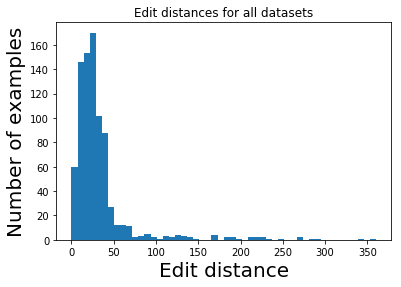

In [29]:
temp = katies_duel_untied_df[['response_vanilla','response_idf']].apply(lambda x: func(*x), axis=1)
plt.hist(temp, bins=50)
plt.title("Edit distances for all datasets")
#     plt.xlim([-1, 11])
plt.xlabel('Edit distance', fontsize=20)
plt.ylabel('Number of examples', fontsize=20)
plt.show()

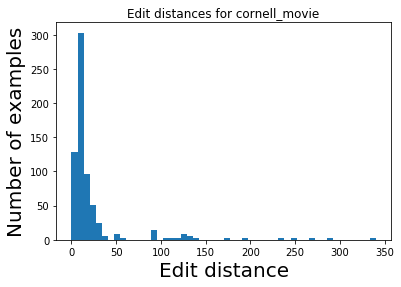

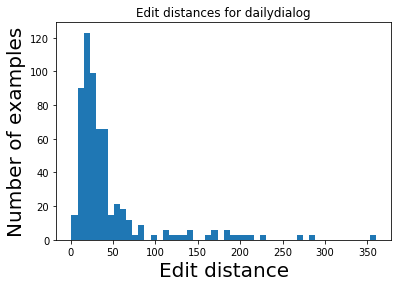

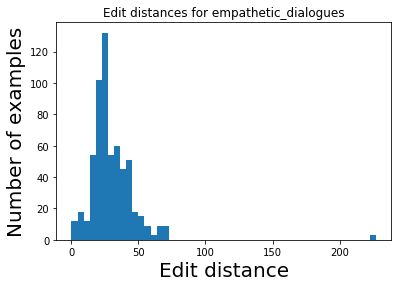

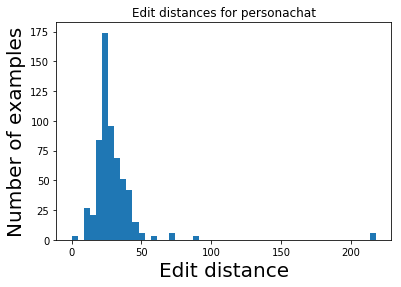

In [30]:
tasks = ['cornell_movie', 'dailydialog', 'empathetic_dialogues', 'personachat']

for task in tasks:
    new_temp_df = katies_duel_df[katies_duel_df["dataset"] == task]
    temp = new_temp_df[['response_vanilla','response_idf']].apply(lambda x: func(*x), axis=1)
    plt.hist(temp, bins=50)
    plt.title("Edit distances for %s" % task)
    #     plt.xlim([-1, 11])
    plt.xlabel('Edit distance', fontsize=20)
    plt.ylabel('Number of examples', fontsize=20)
    plt.show()

In [58]:


katies_duel_untied_df['edit_dist'] = katies_duel_untied_df[['response_vanilla','response_idf']].apply(lambda x: func(*x), axis=1)

In [37]:
katies_duel_untied_df.columns

Index(['dataset', 'model', 'context', 'response_vanilla', 'response_idf',
       'best_overall', 'most_rel', 'most_int', 'none_rel', 'none_int',
       'edit_dist'],
      dtype='object')

In [59]:
with open("sorted_df_s2s.csv", "w") as f:
    f.write(katies_duel_untied_df[katies_duel_untied_df["model"]== "seq2seq"].sort_values(by=['edit_dist'], ascending=False).to_csv())

In [42]:
from statistics import median
for task in tasks:
    new_temp_df = katies_duel_df[katies_duel_df["dataset"] == task]
    temp = new_temp_df[['response_vanilla','response_idf']].apply(lambda x: func(*x), axis=1)
    print("Median of %s is %d" %(task, median(temp)))

Median of cornell_movie is 12
Median of dailydialog is 28
Median of empathetic_dialogues is 26
Median of personachat is 26


In [53]:
def cutoff_func(resp1, resp2, cutoff):
    return nltk.edit_distance(resp1, resp2) > cutoff
medians = [12, 28, 26, 26]
over_med = []
under_len = []
i = 0
for task in tasks:
    new_temp_df = katies_duel_df[katies_duel_df["dataset"] == task]
    over_med.append(new_temp_df[new_temp_df[['response_vanilla','response_idf']].apply(lambda x: cutoff_func(*x, medians[i]), axis=1)])
    i += 1
over_med = pd.DataFrame(over_med, columns = ['dataset', 'model', 'context', 
                                                         'response_vanilla', 'response_idf',
                                                         'best_overall', 'most_rel', 'most_int', 
                                                         'none_rel', 'none_int', 'edit_dist'])



ValueError: Shape of passed values is (4, 1), indices imply (4, 11)

In [52]:
over_med.shape

AttributeError: 'list' object has no attribute 'shape'

In [67]:
katies_duel_untied_df = katies_duel_untied_df.drop(columns="edit_dist")

In [9]:
methods = ["char", "token"]
norms = ["none", "mean"]

def char_mean(resp1, resp2):
    return nltk.edit_distance(resp1, resp2) / ((len(resp1) + len(resp2)) / 2)

def token_mean(resp1, resp2):
    return nltk.edit_distance(resp1.split(" "), resp2.split(" ")) / ((len(resp1) + len(resp2)) / 2)

def char_none(resp1, resp2):
    return nltk.edit_distance(resp1, resp2) 

def token_none(resp1, resp2):
    return nltk.edit_distance(resp1.split(" "), resp2.split(" ")) 
 

'''for met in methods:
    for norm in norms:
        method_name = met + "_" + norm
        print(method_name)
        katies_duel_untied_df[method_name] = katies_duel_untied_df[['response_vanilla','response_idf']].apply(lambda x: globals()[method_name](*x), axis=1)
        with open("%s.csv" %(method_name), "w") as f:
            f.write(katies_duel_untied_df[katies_duel_untied_df["model"]== "seq2seq"].sort_values(by=[method_name], ascending=False).to_csv())'''

'for met in methods:\n    for norm in norms:\n        method_name = met + "_" + norm\n        print(method_name)\n        katies_duel_untied_df[method_name] = katies_duel_untied_df[[\'response_vanilla\',\'response_idf\']].apply(lambda x: globals()[method_name](*x), axis=1)\n        with open("%s.csv" %(method_name), "w") as f:\n            f.write(katies_duel_untied_df[katies_duel_untied_df["model"]== "seq2seq"].sort_values(by=[method_name], ascending=False).to_csv())'

In [29]:
def ret_most_common(resp1, resp2):
    #resp1 = resp1.replace("!", "").replace("?", "").replace(",","").replace(".","")    
    #resp2 = resp2.replace("!", "").replace("?", "").replace(",","").replace(".","")

    return max(Counter(resp1.split(" ")).most_common(1)[0][1], Counter(resp2.split(" ")).most_common(1)[0][1])

In [30]:
no_repeats = katies_duel_untied_df[['response_vanilla','response_idf']].apply(lambda x: ret_most_common(*x), axis=1) < 5
under_two = katies_duel_untied_df[['response_vanilla','response_idf']].apply(lambda x: char_none(*x), axis=1) > 2

to_run = katies_duel_untied_df[no_repeats & under_two]

In [31]:
to_run.shape

(746, 10)

In [32]:
sum(under_two)

806

In [33]:
sum(no_repeats)

772

In [41]:
to_run.columns

Index(['dataset', 'model', 'context', 'response_vanilla', 'response_idf',
       'best_overall', 'most_rel', 'most_int', 'none_rel', 'none_int'],
      dtype='object')

In [44]:
import csv
import random
random.seed(22)

datasets = to_run["dataset"].to_list()
contexts = to_run["context"].to_list()
vanillas = to_run["response_vanilla"].to_list()
idfs = to_run["response_idf"].to_list()
models = to_run["model"].to_list()

with open('duel_one_turker_best_only.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    msg_colnames = []
    for x in range(10):
        msg_colnames += ['msg1_%s' % (x), 'msg2_%s' % (x), 'resp_1_%s' % (x), 'model_1_%s' % (x), 'resp_2_%s' % (x), 'model_2_%s' % (x)]
    spamwriter.writerow(msg_colnames) 
    inps = []
    for i in range(len(to_run)):
        msg1, msg2 = contexts[i].split("BREAK")
        vanilla = vanillas[i ]
        idf = idfs[i ]
        dataset = datasets[i]
        model = models[i ]
        if random.random() < 0.5:
            inps.append([msg1, msg2, vanilla, dataset + " " + model + " vanilla ", idf, dataset + " " + model + " idf "])
        else:
            inps.append([msg1, msg2, idf, dataset + " " + model + " idf ", vanilla, dataset + " " + model + " vanilla "])
        
    random.shuffle(inps)
    for i in range(int(len(to_run) / 10)):
        row = []
        for j in range(10):
            row.extend(inps[i * 10 + j])
        spamwriter.writerow(row)

In [45]:
with open('duel_one_turker_best_only_short.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    msg_colnames = []
    for x in range(6):
        msg_colnames += ['msg1_%s' % (x), 'msg2_%s' % (x), 'resp_1_%s' % (x), 'model_1_%s' % (x), 'resp_2_%s' % (x), 'model_2_%s' % (x)]
    spamwriter.writerow(msg_colnames) 
    row = []
    for i in range(6):
        row.extend(inps[-i])
    spamwriter.writerow(row)

In [46]:
# Data from first weed-out best task

In [47]:
best_raw_df = pd.concat([pd.read_csv('../batches/Batch_3652403_batch_results.csv'), 
                        pd.read_csv('../batches/Batch_3652402_batch_results.csv'), 
                        ], axis=0, sort=False).reset_index()


In [59]:
import re
def standardize_profanity(profane_str):
    return re.sub("([#|\$|%|!|&|@])+([#|\$|%|!|&|@]).*([#|\$|%|!|&|@])+", "****", profane_str)

dueling_methods = ['vanilla', 'idf']

best_df = []
for i in best_raw_df.index:
    row = best_raw_df.loc[i]
    hit_num = i
    worker_id = row['WorkerId']
    
    for ex in range(10): # given to each turker in a single HIT
        
        if np.isnan(row['Answer.best_%s' % ex]): 
            # This may be null from the re-run subset, so skip it (and count after!)
            continue
            
        option_to_method = {}
        method_to_resp = {}
        
        for option in range(1, 2+1):
            
            model_pieces = row['Input.model_%s_%s' % (option, ex)].split(' ')
            dataset, model, method = model_pieces
                
            option_to_method[option] = method
            method_to_resp[method] = row['Input.resp_%s_%s' % (option, ex)]
        option_to_method[3] = "tie"
        best_overall = option_to_method[row['Answer.best_%s' % (ex,)]]
        message1 = row['Input.msg1_%s' % (ex,)]
        message2 = row['Input.msg2_%s' % (ex,)]
        
        
        best_df.append([hit_num, worker_id, dataset, model,
                          message1, message2] + \
                        [method_to_resp[x] for x in dueling_methods] + \
                        [best_overall])

best_df = pd.DataFrame(best_df, columns = ['hit_num', 'worker_id', 'dataset', \
                                           'model', 'message1', 'message2',] + \
                                           ['response_%s' % x for x in dueling_methods] + \
                                           ['best_overall'])

best_df['context'] = best_df['message1'] + " BREAK " + best_df['message2']


In [60]:
best_df

,hit_num,worker_id,dataset,model,message1,message2,response_vanilla,response_idf,best_overall,context
0,0,A3NDPPBACRIXKH,empathetic_dialogues,transformer,~~,my parents are going to a tea room for their a...,that sounds like a nice surprise .,that sounds like fun ! where are you going ?,vanilla,~~ BREAK my parents are going to a tea room fo...
1,0,A3NDPPBACRIXKH,cornell_movie,transformer,"pack the bags, we have to move.","also, this is your bill for the last week.",i do n't know .,"yes , sir .",idf,"pack the bags, we have to move. BREAK also, ..."
2,0,A3NDPPBACRIXKH,empathetic_dialogues,transformer,cool. thats a fun hobby.,thank you,i bet that was fun,that sounds like fun !,tie,cool. thats a fun hobby. BREAK thank you
3,0,A3NDPPBACRIXKH,personachat,transformer,you sound very smart . i am a simple country g...,i like the simple life too . iced tea and cou...,do you have any kids ?,what kind of music do you like ?,vanilla,you sound very smart . i am a simple country g...
4,0,A3NDPPBACRIXKH,personachat,transformer,good for him . i love my stereo,what other things do you like to do ?,i like to go to the beach,what kind of music do you like ?,vanilla,good for him . i love my stereo BREAK what oth...
5,0,A3NDPPBACRIXKH,empathetic_dialogues,seq2seq,that doesn't sound good. what happened that wa...,the food was pretty bad and the service didn't...,i 'm sorry you have to deal with that .,well that 's good to hear . what happened ?,vanilla,that doesn't sound good. what happened that wa...
6,1,A1TGV7LT6LTIQU,empathetic_dialogues,transformer,~~,my parents are going to a tea room for their a...,that sounds like a nice surprise .,that sounds like fun ! where are you going ?,tie,~~ BREAK my parents are going to a tea room fo...
7,1,A1TGV7LT6LTIQU,cornell_movie,transformer,"pack the bags, we have to move.","also, this is your bill for the last week.",i do n't know .,"yes , sir .",idf,"pack the bags, we have to move. BREAK also, ..."
8,1,A1TGV7LT6LTIQU,empathetic_dialogues,transformer,cool. thats a fun hobby.,thank you,i bet that was fun,that sounds like fun !,tie,cool. thats a fun hobby. BREAK thank you
9,1,A1TGV7LT6LTIQU,personachat,transformer,you sound very smart . i am a simple country g...,i like the simple life too . iced tea and cou...,do you have any kids ?,what kind of music do you like ?,vanilla,you sound very smart . i am a simple country g...


In [76]:
best_untied_df = []
for_kappa = []
for_cohen = []
for (dataset, model), setting_df in best_df.groupby(['dataset', 'model']):
    for context, df in setting_df.groupby('context'):
        if df.shape[0] !=3: 
            print(dataset, model, method, df.shape)
            continue
        best_untied_df.append([dataset, model, context, 
                               df['response_vanilla'].values[0], df['response_idf'].values[0],
                              Counter(df['best_overall'].values).most_common(1)[0][0]])
        for_kappa.append([Counter(df['best_overall'].values)["vanilla"], Counter(df['best_overall'].values)["idf"], Counter(df['best_overall'].values)["tie"]])
        
best_untied_df = pd.DataFrame(best_untied_df, columns = ['dataset', 'model', 'context', 
                                                         'response_vanilla', 'response_idf',
                                                         'best_overall'])
        


empathetic_dialogues transformer idf (6, 10)


In [88]:
best_untied_df.shape

(744, 6)

In [86]:
rates = []
for item in for_kappa:
    if item[2] < 2:
        rates.append(True)
    else:
        rates.append(False)

untied_for_rerun = best_untied_df[rates]

In [87]:
untied_for_rerun.shape

(515, 6)

In [78]:
from statsmodels.stats.inter_rater import fleiss_kappa
fleiss_kappa(for_kappa)

0.09236360453475367

In [75]:
for_kappa

[[1, 0, 2],
 [0, 1, 2],
 [0, 3, 0],
 [1, 1, 1],
 [0, 2, 1],
 [0, 2, 1],
 [0, 1, 2],
 [1, 1, 1],
 [0, 1, 2],
 [1, 1, 1],
 [0, 1, 2],
 [2, 1, 0],
 [1, 1, 1],
 [2, 0, 1],
 [1, 0, 2],
 [1, 1, 1],
 [0, 1, 2],
 [2, 0, 1],
 [0, 1, 2],
 [2, 0, 1],
 [0, 2, 1],
 [2, 1, 0],
 [2, 0, 1],
 [2, 0, 1],
 [0, 1, 2],
 [0, 3, 0],
 [1, 1, 1],
 [1, 0, 2],
 [0, 1, 2],
 [1, 1, 1],
 [1, 0, 2],
 [0, 2, 1],
 [2, 0, 1],
 [2, 0, 1],
 [2, 0, 1],
 [3, 0, 0],
 [0, 1, 2],
 [0, 2, 1],
 [3, 0, 0],
 [0, 1, 2],
 [0, 0, 3],
 [1, 0, 2],
 [0, 0, 3],
 [2, 0, 1],
 [1, 0, 2],
 [0, 0, 3],
 [0, 3, 0],
 [0, 1, 2],
 [2, 0, 1],
 [0, 1, 2],
 [1, 0, 2],
 [0, 2, 1],
 [0, 2, 1],
 [0, 2, 1],
 [0, 2, 1],
 [1, 1, 1],
 [1, 0, 2],
 [1, 2, 0],
 [0, 2, 1],
 [0, 2, 1],
 [3, 0, 0],
 [2, 0, 1],
 [2, 0, 1],
 [0, 1, 2],
 [1, 1, 1],
 [1, 2, 0],
 [3, 0, 0],
 [2, 0, 1],
 [0, 0, 3],
 [1, 1, 1],
 [1, 0, 2],
 [0, 0, 3],
 [1, 0, 2],
 [2, 0, 1],
 [0, 0, 3],
 [2, 0, 1],
 [1, 0, 2],
 [0, 2, 1],
 [1, 2, 0],
 [3, 0, 0],
 [0, 1, 2],
 [1, 0, 2],
 [0, 1, 2],
 [1,

In [85]:


from sklearn.metrics import cohen_kappa_score

tot_labs = []
for objs in for_kappa:
    labs = []
    for i in range(objs[0]):
        labs.append(0)
    for i in range(objs[1]):
        labs.append(1)
    for i in range(objs[2]):
        labs.append(2)
    tot_labs.append(labs)
r1 = [x[0] for x in tot_labs]
r2 = [x[1] for x in tot_labs]
r3 = [x[2] for x in tot_labs]

print((cohen_kappa_score(r1, r2) + cohen_kappa_score(r2, r3) + cohen_kappa_score(r1, r3)) / 3.0)



0.19684887323177588


In [89]:
tot_labs = []
for objs in for_kappa:
    labs = []
    for i in range(objs[0]):
        labs.append(0)
    for i in range(objs[1]):
        labs.append(0)
    for i in range(objs[2]):
        labs.append(2)
    tot_labs.append(labs)
r1 = [x[0] for x in tot_labs]
r2 = [x[1] for x in tot_labs]
r3 = [x[2] for x in tot_labs]

print("kappa for tie or not")
print((cohen_kappa_score(r1, r2) + cohen_kappa_score(r2, r3) + cohen_kappa_score(r1, r3)) / 3.0)



kappa for tie or not
0.18004769926233985
